## GaussianExample with original step2 method

In the original version of the GaussianExample, step2 is implemented in a simpler way than in the papers.  Instead of updating the weights in each iteration of step2, it always uses weight=1 for the gen-level sample in the compaison.

In the original OmniFold paper, they propose instead updating the weights of the previous iteration, rather than always starting from the beginning (weight=1).  I'll try to implement the original version here.


In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["text.usetex"]=False 

In [2]:
%matplotlib inline
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>")

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2023-01-26 20:12:55.063593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 20:12:55.063820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 20:12:55.080156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 20:12:55.080397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 20:12:55.080569: I tensorflow/compiler/xla/stream_executo

In [4]:
# Define default plot styles  

from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

In [5]:
# Check Versions
import tensorflow as tf
print(tf.__version__)

2.11.0


# OmniFold Gaussian Toy Example

## Setup the Datasets

In [6]:
mu0 = 0
sigma0 = 1

eff = 0.1 #fraction of true but not reco
fake = 0.1 #fraction of reco but not true


##-- original value
#back = 0.1 #fraction of a background process that we would like to subtract



## Owen: learning hyperparameters

In [7]:



##-- originals

max_epochs = 200
batch_size_setval = 10000
learning_rate_setval = 1e-3
patience_setval = 10

back = 0.1 #fraction of a background process that we would like to subtract
background_param = (0, 1.2)  # background
N = 10**5






##-- alt1
##-- more thorough set with more events, higher background, wider background width 
##  3 min + 50 min

#max_epochs = 200
#batch_size_setval = 1000
#learning_rate_setval = 1e-4
#patience_setval = 40

#back = 0.2 #fraction of a background process that we would like to subtract
#background_param = (0, 3)  # background
#N = 3*10**5






##-- alt2
##-- more thorough set with a lot more events, higher background, wider background width 
##   About 3 hours.

#max_epochs = 200
#batch_size_setval = 1000
#learning_rate_setval = 1e-4
#patience_setval = 40

#back = 0.2 #fraction of a background process that we would like to subtract
#background_param = (0, 3)  # background
#N = 10**6





##-- alt5
##   similar to alt4 but with sample size of 1M.
##-- more thorough set with more events, higher background, wider background width 
##  about 30 min

max_epochs = 200
batch_size_setval = 16384
learning_rate_setval = 1e-4
patience_setval = 40

back = 0.2 #fraction of a background process that we would like to subtract
background_param = (0, 3)  # background
N = 10**6



In [8]:
%%time

#N = 10**5


# param = (mu, sigma)
theta0_param = (mu0, sigma0)  # synthetic sample
theta_unknown_param = (0.2, 0.8)  # this is the data (the target)
#background_param = (0, 1.2)  # background
#background_param = (0, 3)  # background
epsilon = sigma0 / 2.  # Smearing width

dummyval = -10 #a value for examples that don't pass one of the measured/ideal selections

#Synthetic
theta0_G = np.random.normal(theta0_param[0], theta0_param[1],N)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_G])  # Detector smearing for synthetic sample
pass_reco = np.random.binomial(1,1.-eff,len(theta0_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta0_G)) # what a concise Toy MC with cuts!
theta0_S[pass_reco==0] = dummyval
theta0_G[pass_truth==0] = dummyval

theta0_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta0_S_withback = np.concatenate([theta0_S,theta0_background]) #smeared synthetic (mc_reco)+background
theta0_G_withback = np.concatenate([theta0_G,-np.ones(int(N*back))*dummyval]) #gen synthetic (mc_truth)+background

theta0 = np.stack([theta0_G, theta0_S], axis=1)
labels0 = np.zeros(len(theta0))

#Natural
theta_unknown_G = np.random.normal(theta_unknown_param[0],theta_unknown_param[1], N) # Nature, particle-level analog
theta_unknown_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta_unknown_G]) # Measured Data analog
pass_reco = np.random.binomial(1,1.-eff,len(theta_unknown_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta_unknown_G))
theta_unknown_S[pass_reco==0] = dummyval
theta_unknown_G[pass_truth==0] = dummyval #emulates cuts done in an analysis

theta_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta_unknown_S_withback = np.concatenate([theta_unknown_S,theta_background]) #Nature+background
theta_unknown_G_withback = np.concatenate([theta_unknown_G,-np.ones(int(N*back))*dummyval]) #Data+Background

theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=1)
labels_unknown = np.ones(len(theta_unknown))

CPU times: user 4.91 s, sys: 56.6 ms, total: 4.97 s
Wall time: 4.97 s


In [9]:
theta0_G

array([-10.        ,   0.7809088 ,  -0.56505888, ...,   0.33156939,
        -0.36750336, -10.        ])

In [10]:
theta0_S

array([ 1.63726592,  0.64124504, -0.41135563, ...,  0.33854484,
       -0.60148754,  0.49806421])

In [11]:
theta0

array([[-10.        ,   1.63726592],
       [  0.7809088 ,   0.64124504],
       [ -0.56505888,  -0.41135563],
       ...,
       [  0.33156939,   0.33854484],
       [ -0.36750336,  -0.60148754],
       [-10.        ,   0.49806421]])

In [12]:
labels0

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
labels0.shape

(1000000,)

In [14]:
theta0.shape

(1000000, 2)

In [15]:
labels_unknown

array([1., 1., 1., ..., 1., 1., 1.])

In [16]:
labels_unknown.shape

(1000000,)

/tmp/ipykernel_3168250/177983796.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


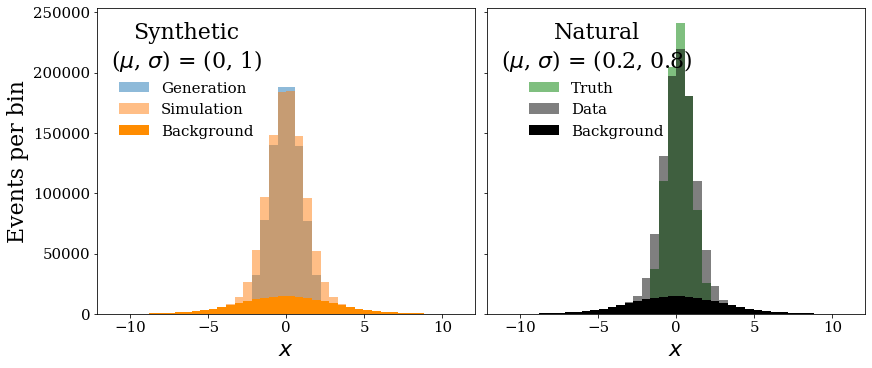

In [17]:
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S_withback[theta0_S_withback!=dummyval], bins=bins, **plot_style_2, label='Simulation')
ax[0].hist(theta0_S_withback[theta0_G_withback==-dummyval], bins=bins, color="darkorange", label='Background')
legend = ax[0].legend(
    title=r'Synthetic''\n''($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel(r'$x$')
ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, **plot_style_2, label='Data',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_G_withback==-dummyval], bins=bins, label='Background',color="black")
legend = ax[1].legend(
    title=r'Natural''\n''($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Unfold Data

In [18]:
iterations = 4

In [19]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S)) #synthetic, measured.
yvals_1 = np.concatenate((labels0, labels_unknown)) 
#QUESTION: At what point are theses mixed? Avoid [0,0,0...0,1,1...1,1,1]
#I think at test_train_split function

xvals_2 = np.concatenate((theta0_G, theta0_G)) 
#QUESTION whay 0_G twice? Because theta_unknown_G is ultimate target (particle level – nature), 
#and can't be used as an input to the training.
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)


nn_output = np.zeros( shape=(iterations, 2, len(theta0)))

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

#earlystopping = EarlyStopping(patience=10,
#                              verbose=1,
#                              restore_best_weights=True)

earlystopping = EarlyStopping(patience=patience_setval,
                              verbose=1,
                              restore_best_weights=True)

2023-01-26 20:13:01.025923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 20:13:01.026252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 20:13:01.026429: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 20:13:01.026589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 20:13:01.026748: I tensorflow/compiler/xla/stream_executo

In [20]:
xvals_1

array([ 1.63726592,  0.64124504, -0.41135563, ...,  0.20327187,
        0.93358888,  0.59839889])

In [21]:
xvals_1.shape

(2000000,)

In [22]:
yvals_1

array([0., 0., 0., ..., 1., 1., 1.])

In [23]:
yvals_1.shape

(2000000,)

In [24]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights)) 
#Question: how is the model passed? Stored in memory before function is called?
#QUESTION: is this p(w,X)/p(w',X'), where p is PDF of (x)?
#reweights sim to data, then 

In [25]:
%%time

#We can do the background subtraction as part of the iterative unfolding, but it is easier to do it first.


    
x_data_and_MCback = np.concatenate([theta0_S_withback[theta0_G_withback==-dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]])
    
y_data_and_MCback = np.concatenate([np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.zeros(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])
    
W_data_and_MCback = np.concatenate([-1.*np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
    x_data_and_MCback, y_data_and_MCback, W_data_and_MCback)

    


CPU times: user 124 ms, sys: 8.19 ms, total: 132 ms
Wall time: 132 ms


## Owen's notes

See my more detailed notes in this file on my laptop: /Users/owen/work/eic/omnifold/2023-01-23-notes.docx

Here's a summary of how the BG subtraction works.  

- The NN is given a binary classification task where the two categories are signal-only (y=1, call this a) and signal plus background (y=0, call this b).

- The signal-only sample is constructed by combining the "data" (theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]) with a BG sample (theta0_S_withback[theta0_G_withback==-dummyval]), where the data weight is +1 and the BG weight is -1.  This does the BG subtraction in the loss function because the sum of the BG sample, with weight -1, will cancel the sum of the BG component of the data.

- The NN output f is an estimation of the probability that an event is in the class a and this is approximately a/(a+b).

- The signal fraction is given by a/b.  To get this from f, it's Fr(sig) = f/(1-f) = a/b, which is also the likelihood ratio or the ratio of the probabilities of the two classes.

This BG subtraction trick is to cancel it in the loss function by adding it to the signal+bg sample with a negative weight.


In [26]:
%%time

#model.compile(loss='binary_crossentropy',
#              optimizer='Adam',
#              metrics=['accuracy'])

#model.compile(loss='binary_crossentropy',
#              optimizer='Adam',
#              metrics=['accuracy'],
#              weighted_metrics=[])


#training_hist = model.fit(X_train_1,
#          Y_train_1,
#          sample_weight=w_train_1,
#          epochs=200,
#          batch_size=10000,
#          validation_data=(X_test_1, Y_test_1, w_test_1),
#          callbacks=[earlystopping],
#          verbose=1)

the_optimizer = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )

model.compile(loss='binary_crossentropy',
              optimizer=the_optimizer,
              metrics=['accuracy'],
              weighted_metrics=[])


training_hist = model.fit(X_train_1,
          Y_train_1,
          sample_weight=w_train_1,
          epochs=100,
          batch_size=batch_size_setval,
          validation_data=(X_test_1, Y_test_1, w_test_1),
          callbacks=[earlystopping],
          verbose=1)

Epoch 1/100


2023-01-26 20:17:56.003865: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-26 20:17:56.006518: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f00dc00fbb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-26 20:17:56.006541: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-01-26 20:17:56.006548: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-01-26 20:17:56.012969: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-26 20:17:56.119722: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is log

110/110 [==============================] - 95s 860ms/step - loss: 0.5772 - accuracy: 0.4836 - val_loss: 0.5677 - val_accuracy: 0.4575
Epoch 2/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5645 - accuracy: 0.4586 - val_loss: 0.5642 - val_accuracy: 0.4575
Epoch 3/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5626 - accuracy: 0.4586 - val_loss: 0.5630 - val_accuracy: 0.4575
Epoch 4/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5614 - accuracy: 0.4586 - val_loss: 0.5621 - val_accuracy: 0.4575
Epoch 5/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5605 - accuracy: 0.4586 - val_loss: 0.5613 - val_accuracy: 0.4575
Epoch 6/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5597 - accuracy: 0.4586 - val_loss: 0.5606 - val_accuracy: 0.4575
Epoch 7/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5590 - accuracy: 0.4586 - val_loss: 0.5600 - val_accuracy: 0.4575
Epoch 8/

110/110 [==============================] - 0s 3ms/step - loss: 0.5537 - accuracy: 0.4586 - val_loss: 0.5567 - val_accuracy: 0.4575
Epoch 59/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5537 - accuracy: 0.4586 - val_loss: 0.5567 - val_accuracy: 0.4575
Epoch 60/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5536 - accuracy: 0.4586 - val_loss: 0.5567 - val_accuracy: 0.4575
Epoch 61/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5536 - accuracy: 0.4586 - val_loss: 0.5567 - val_accuracy: 0.4575
Epoch 62/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5536 - accuracy: 0.4586 - val_loss: 0.5567 - val_accuracy: 0.4575
Epoch 63/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5536 - accuracy: 0.4586 - val_loss: 0.5567 - val_accuracy: 0.4575
Epoch 64/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5535 - accuracy: 0.4586 - val_loss: 0.5567 - val_accuracy: 0.4575
Epoch

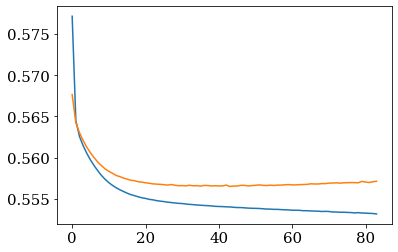

In [27]:
plt.plot( training_hist.history['loss'])
plt.plot( training_hist.history['val_loss'])

In [28]:
w_data = reweight(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])

111/111 [==============================] - 0s 604us/step


In [29]:
w_data_bgsub_only = w_data

/tmp/ipykernel_3168250/236819712.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


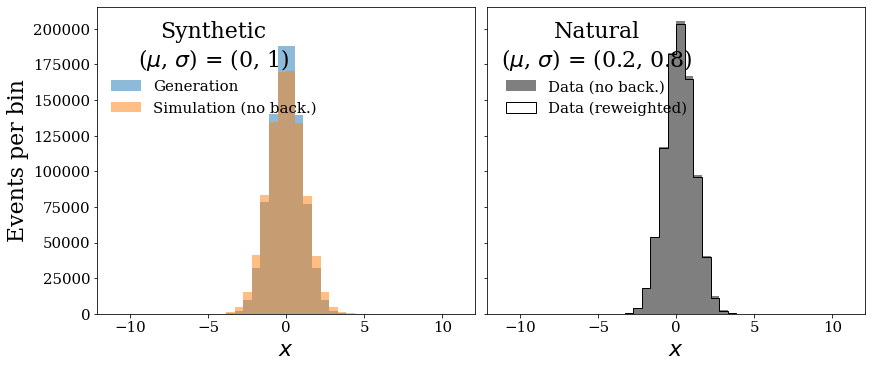

In [30]:
i=0
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel('Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S!=dummyval], bins=bins, **plot_style_2, label='Simulation (no back.)')
legend = ax[0].legend(
    title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
#ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S[theta_unknown_S!=dummyval], bins=bins, **plot_style_2, label='Data (no back.)',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, histtype="step", label='Data (reweighted)',color="black",weights=w_data)
legend = ax[1].legend(
    title='Natural\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()
plt.savefig("plot_"+str(i)+"_datareweight.pdf")

In [31]:
model_output_bgsub = model.predict(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], batch_size=10000)

111/111 [==============================] - 0s 637us/step


In [32]:
model_output_bgsub

array([[0.47923028],
       [0.3192585 ],
       [0.4773391 ],
       ...,
       [0.00723621],
       [0.4233277 ],
       [0.48019102]], dtype=float32)

In [33]:
model_output_bgsub.shape

(1100126, 1)

In [34]:
squeezed_model_output = np.squeeze(model_output_bgsub)

In [35]:
squeezed_model_output

array([0.47923028, 0.3192585 , 0.4773391 , ..., 0.00723621, 0.4233277 ,
       0.48019102], dtype=float32)

In [36]:
squeezed_model_output.shape

(1100126,)

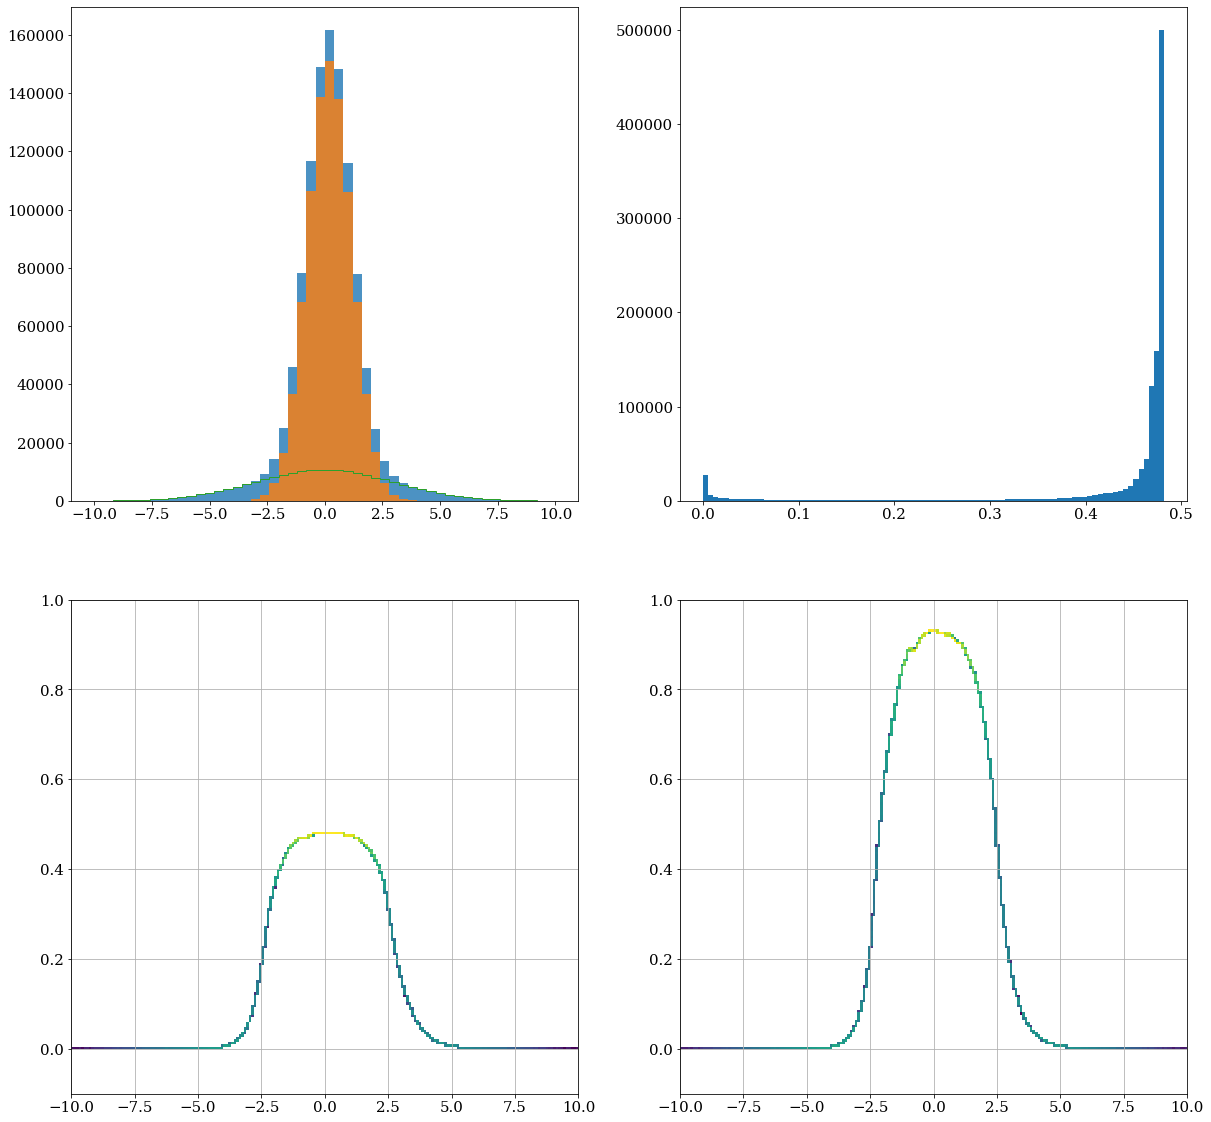

In [37]:
fig,ax = plt.subplots(2,2,figsize=(20,20))



ax[0][0].hist( theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], range=[-10,10], bins=50, alpha=0.8)
ax[0][0].hist( theta_unknown_S[theta_unknown_S!=dummyval], range=[-10,10], bins=50, alpha=0.8)
ax[0][0].hist( theta_background, range=[-10,10], bins=50, histtype="step")

ax[0][1].hist( squeezed_model_output, bins=90 )


ax[1][0].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         squeezed_model_output,
         density=True,
         bins=200,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1][0].grid()

ax[1][1].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data,
         density=True,
         bins=200,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1][1].grid()

plt.show()

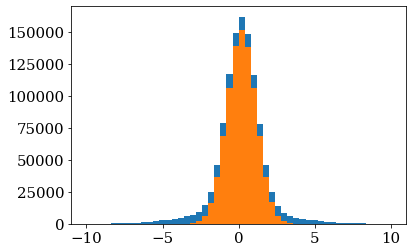

In [38]:
hist_data_all = plt.hist( theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], range=[-10,10], bins=50 )
hist_data_signal = plt.hist( theta_unknown_S[theta_unknown_S!=dummyval], range=[-10,10], bins=50)

In [39]:
hist_data_all

(array([5.90000e+01, 7.30000e+01, 1.24000e+02, 1.71000e+02, 2.52000e+02,
        3.28000e+02, 5.07000e+02, 7.20000e+02, 9.28000e+02, 1.28100e+03,
        1.66400e+03, 2.16300e+03, 2.65400e+03, 3.34500e+03, 3.91700e+03,
        4.73200e+03, 5.72000e+03, 6.91500e+03, 9.34200e+03, 1.45110e+04,
        2.51410e+04, 4.60950e+04, 7.83180e+04, 1.16768e+05, 1.49106e+05,
        1.61597e+05, 1.48224e+05, 1.16062e+05, 7.77760e+04, 4.56980e+04,
        2.46880e+04, 1.35660e+04, 8.45200e+03, 6.06200e+03, 4.88600e+03,
        3.93600e+03, 3.25200e+03, 2.67600e+03, 2.08500e+03, 1.63100e+03,
        1.31500e+03, 9.51000e+02, 7.77000e+02, 4.93000e+02, 3.71000e+02,
        2.48000e+02, 1.64000e+02, 1.03000e+02, 7.00000e+01, 5.40000e+01]),
 array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
         -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
         -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
          0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2

In [40]:
hist_data_all[0]

array([5.90000e+01, 7.30000e+01, 1.24000e+02, 1.71000e+02, 2.52000e+02,
       3.28000e+02, 5.07000e+02, 7.20000e+02, 9.28000e+02, 1.28100e+03,
       1.66400e+03, 2.16300e+03, 2.65400e+03, 3.34500e+03, 3.91700e+03,
       4.73200e+03, 5.72000e+03, 6.91500e+03, 9.34200e+03, 1.45110e+04,
       2.51410e+04, 4.60950e+04, 7.83180e+04, 1.16768e+05, 1.49106e+05,
       1.61597e+05, 1.48224e+05, 1.16062e+05, 7.77760e+04, 4.56980e+04,
       2.46880e+04, 1.35660e+04, 8.45200e+03, 6.06200e+03, 4.88600e+03,
       3.93600e+03, 3.25200e+03, 2.67600e+03, 2.08500e+03, 1.63100e+03,
       1.31500e+03, 9.51000e+02, 7.77000e+02, 4.93000e+02, 3.71000e+02,
       2.48000e+02, 1.64000e+02, 1.03000e+02, 7.00000e+01, 5.40000e+01])

In [41]:
hist_axis = hist_data_all[1]

In [42]:
hist_axis

array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
        -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
        -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
         0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
         4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,   7.2,   7.6,
         8. ,   8.4,   8.8,   9.2,   9.6,  10. ])

In [43]:
hist_axis_centers = np.ones(50)
for i in range(0,50):
    hist_axis_centers[i] = 0.5*(hist_axis[i]+hist_axis[i+1])
    #print(i, hist_axis_centers[i])

In [44]:
signal_frac = (hist_data_signal[0])/(hist_data_all[0])

In [45]:
signal_frac

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.53178453e-03, 5.07185123e-03,
       1.67832168e-02, 7.59219089e-02, 2.14193963e-01, 4.29398387e-01,
       6.48025138e-01, 7.95899772e-01, 8.71166271e-01, 9.09786928e-01,
       9.29674192e-01, 9.34305711e-01, 9.29707740e-01, 9.12693216e-01,
       8.75912878e-01, 8.04717931e-01, 6.78264744e-01, 4.57467197e-01,
       2.32371036e-01, 8.49554602e-02, 2.43553009e-02, 3.81097561e-03,
       9.22509225e-04, 3.73692078e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

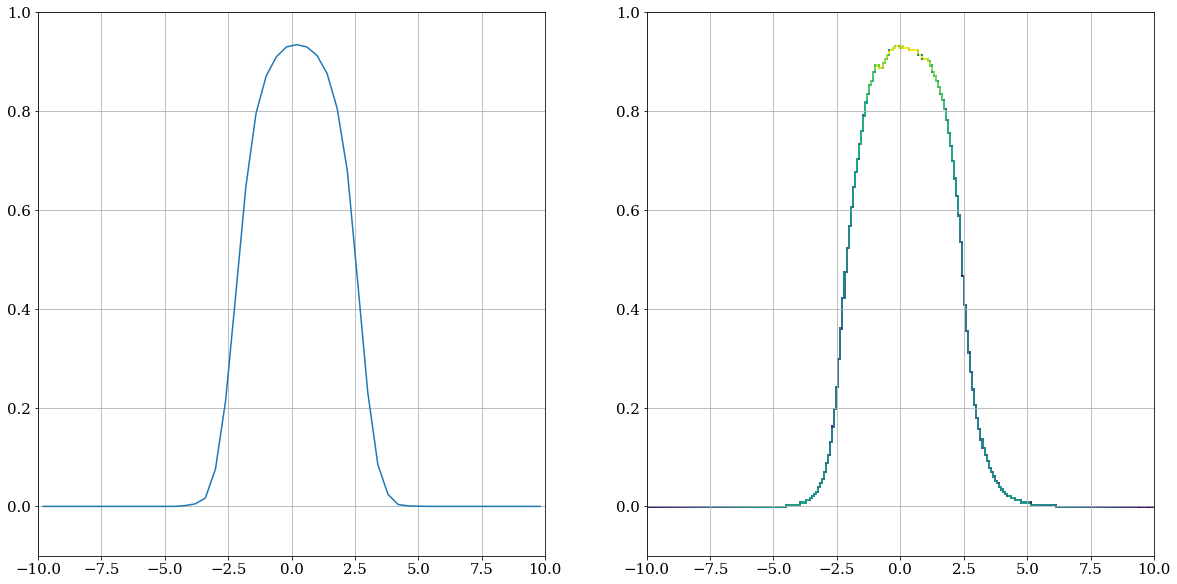

In [46]:
fig,ax = plt.subplots(1,2,figsize=(20,10))


ax[0].plot(hist_axis_centers,signal_frac)
ax[0].set_ylim(-0.1,1)
ax[0].set_xlim(-10,10)
ax[0].grid()

ax[1].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data_bgsub_only,
         density=True,
         bins=250,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1].grid()

plt.show()

In [47]:
of_training_history = np.zeros(shape=(4,2,1000))
of_training_history_val = np.zeros(shape=(4,2,1000))


## OmniFold part starts here

In [48]:
# initial iterative weights are ones
weights_pull = np.ones(len(theta0_S))
weights_push = np.ones(len(theta0_S))

#-- owen: adding this
weights_push_last_iteration = np.ones(len(theta0_S))

In [49]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))
yvals_1 = np.concatenate((labels0, np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))))

In [50]:
%%time

for i in range(iterations):
    print("\n\n\nITERATION: {}\n".format(i + 1))

    
    
    
    weights_push_last_iteration = weights_push
    
    
    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("\n\n\n Iteration %d,  STEP 1, events that pass reco\n\n\n" % (i+1))
    

    weights_1 = np.concatenate((weights_push, w_data))
    #QUESTION: concatenation here confuses me
    # actual weights for Sim., ones for Data (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1) #REMINDER: made up of synthetic+measured

#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])

    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    
    
    this_hist = model.fit(X_train_1[X_train_1!=dummyval],
              Y_train_1[X_train_1!=dummyval],
              sample_weight=w_train_1[X_train_1!=dummyval],
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1[X_test_1!=dummyval], Y_test_1[X_test_1!=dummyval], w_test_1[X_test_1!=dummyval]),
              callbacks=[earlystopping],
              verbose=1)

    for ei in range(0,len(this_hist.history['loss'])):
        of_training_history[i,0,ei] = this_hist.history['loss'][ei]
        of_training_history_val[i,0,ei] = this_hist.history['val_loss'][ei]
    
    
    weights_pull = weights_push * reweight(theta0_S) 
    #QUESTION: above model used in reweight function (model.predict)?
    #QUESTION: Model trains until synthetic is indistinguishable from data? How does this work? 
    #How are weights then iteratively multiplied?
 

    ##-- owen: save NN output for each iteration, step.
    nn_output[i,0,:] = np.squeeze(  model.predict(theta0_S, batch_size=10000) )


    
    
    
    


    print("\n\n\n Iteration %d,  STEP 1, events that do NOT pass reco\n\n\n" % (i+1))

    ###
    #Need to do something with events that don't pass reco.
    
    #One option is to take the prior:
    #weights_pull[theta0_S==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_true>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_G[theta0_S!=dummyval],theta0_G[theta0_S!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_G[theta0_S!=dummyval])),np.zeros(len(theta0_G[theta0_S!=dummyval]))])
    weights_1b = np.concatenate([weights_pull[theta0_S!=dummyval],np.ones(len(theta0_G[theta0_S!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    
    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])
    
    
    this_hist = model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)


        
        
        
        
        
        
        
    
    
    
    
    average_vals = reweight(theta0_G[theta0_S==dummyval])
    weights_pull[theta0_S==dummyval] = average_vals
    ###
    
    
    ##-- owen: the syntax below is a bit confusing.
    #          it is equivalent to weights[i,0,:] I think.  See Python-syntax-testing notebook.
    weights[i, :1, :] = weights_pull
    
    
    
    
    
    
    
    
    
    ##-----------------------------------------------------------------------
    
    
    

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\n\n\n Iteration %d,  STEP 2, events that pass reco\n\n\n" % (i+1))

    #weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.
    
    ##-- owen: this is the way it's done in the papers (I think).
    #          At this point weights_push should still have the values from the end of the last iteration.
    weights_2 = np.concatenate((weights_push, weights_pull))
    
    
    

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    

    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    
    
    this_hist = model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    for ei in range(0,len(this_hist.history['loss'])):
        of_training_history[i,1,ei] = this_hist.history['loss'][ei]
        of_training_history_val[i,1,ei] = this_hist.history['val_loss'][ei]        
    
    
    
    #weights_push = reweight(theta0_G)    
    
    
    #-- owen: this is the way it's done in the papers (I think)
    weights_push = weights_push * reweight(theta0_G)    
    
    
    
    
    
    ##-- owen: save NN output for each iteration, step.
    nn_output[i,1,:] = np.squeeze(  model.predict(theta0_G, batch_size=10000) )
    
    
    print("\n\n\n Iteration %d,  STEP 2, events that do NOT pass reco\n\n\n" % (i+1))
    

    ###
    #Need to do something with events that don't pass truth    
    
    #One option is to take the prior:
    #weights_push[theta0_G==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_reco>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_S[theta0_G!=dummyval],theta0_S[theta0_G!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_S[theta0_G!=dummyval])),np.zeros(len(theta0_S[theta0_G!=dummyval]))])
    weights_1b = np.concatenate([weights_push[theta0_G!=dummyval],np.ones(len(theta0_S[theta0_G!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
    
    
#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    
    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    

    
    
    model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)
    
    average_vals = reweight(theta0_S[theta0_G==dummyval])
    weights_push[theta0_G==dummyval] = average_vals
    ###    

    
    ##-- owen: the syntax below is a bit confusing.
    #          it is equivalent to weights[i,1,:] I think.  See Python-syntax-testing notebook.
    
    weights[i, 1:2, :] = weights_push
    
    
    
    
    
    
    
    
    
    




ITERATION: 1




 Iteration 1,  STEP 1, events that pass reco



Epoch 1/200
92/92 [==============================] - 79s 862ms/step - loss: 0.6139 - accuracy: 0.5183 - val_loss: 0.6129 - val_accuracy: 0.5283
Epoch 2/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6124 - accuracy: 0.5291 - val_loss: 0.6126 - val_accuracy: 0.5276
Epoch 3/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6122 - accuracy: 0.5282 - val_loss: 0.6125 - val_accuracy: 0.5270
Epoch 4/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6122 - accuracy: 0.5279 - val_loss: 0.6125 - val_accuracy: 0.5269
Epoch 5/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6121 - accuracy: 0.5277 - val_loss: 0.6125 - val_accuracy: 0.5269
Epoch 6/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6121 - accuracy: 0.5278 - val_loss: 0.6124 - val_accuracy: 0.5270
Epoch 7/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6121 - a

92/92 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.5281 - val_loss: 0.6123 - val_accuracy: 0.5268
Epoch 59/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.5279 - val_loss: 0.6123 - val_accuracy: 0.5274
Epoch 60/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.5279 - val_loss: 0.6123 - val_accuracy: 0.5266
Epoch 61/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.5279 - val_loss: 0.6123 - val_accuracy: 0.5272
Epoch 62/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.5279 - val_loss: 0.6123 - val_accuracy: 0.5272
Epoch 63/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.5279 - val_loss: 0.6123 - val_accuracy: 0.5268
Epoch 64/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.5280 - val_loss: 0.6123 - val_accuracy: 0.5268
Epoch 65/200
92/92 

Epoch 116/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.5337 - val_loss: 0.6123 - val_accuracy: 0.5324
Epoch 117/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.5337 - val_loss: 0.6123 - val_accuracy: 0.5325
Epoch 118/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.5337 - val_loss: 0.6123 - val_accuracy: 0.5330
Epoch 119/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.5340 - val_loss: 0.6123 - val_accuracy: 0.5320
Epoch 120/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.5338 - val_loss: 0.6123 - val_accuracy: 0.5322
Epoch 121/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.5341 - val_loss: 0.6123 - val_accuracy: 0.5333
Epoch 122/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.5341 - val_loss: 0.6123 - val_accuracy: 0.5336

92/92 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.5356 - val_loss: 0.6123 - val_accuracy: 0.5339
Epoch 174/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.5354 - val_loss: 0.6123 - val_accuracy: 0.5349
Epoch 175/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.5356 - val_loss: 0.6123 - val_accuracy: 0.5346
Epoch 176/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.5354 - val_loss: 0.6123 - val_accuracy: 0.5348
Epoch 177/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.5355 - val_loss: 0.6123 - val_accuracy: 0.5342
Epoch 178/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.5356 - val_loss: 0.6123 - val_accuracy: 0.5346
Epoch 179/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6119 - accuracy: 0.5357 - val_loss: 0.6123 - val_accuracy: 0.5345
Epoch 180/200

83/83 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.4995 - val_loss: 0.6853 - val_accuracy: 0.5011
Epoch 30/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.4998 - val_loss: 0.6853 - val_accuracy: 0.5011
Epoch 31/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.4997 - val_loss: 0.6853 - val_accuracy: 0.5006
Epoch 32/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.4998 - val_loss: 0.6854 - val_accuracy: 0.5005
Epoch 33/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.4997 - val_loss: 0.6853 - val_accuracy: 0.5010
Epoch 34/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.4998 - val_loss: 0.6853 - val_accuracy: 0.5010
Epoch 35/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.4996 - val_loss: 0.6854 - val_accuracy: 0.5008
Epoch 36/200
83/83 

Epoch 87/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.4996 - val_loss: 0.6853 - val_accuracy: 0.5012
Epoch 88/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.4998 - val_loss: 0.6853 - val_accuracy: 0.5006
Epoch 89/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.4997 - val_loss: 0.6853 - val_accuracy: 0.5011
Epoch 90/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.4996 - val_loss: 0.6853 - val_accuracy: 0.5011
Epoch 91/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.4996 - val_loss: 0.6853 - val_accuracy: 0.5006
Epoch 92/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.4998 - val_loss: 0.6853 - val_accuracy: 0.5010
Epoch 93/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.4997 - val_loss: 0.6853 - val_accuracy: 0.5007
Epoch 

92/92 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.4998 - val_loss: 0.6857 - val_accuracy: 0.5000
Epoch 10/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.4998 - val_loss: 0.6857 - val_accuracy: 0.5000
Epoch 11/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.5000 - val_loss: 0.6857 - val_accuracy: 0.5000
Epoch 12/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.5001 - val_loss: 0.6858 - val_accuracy: 0.5000
Epoch 13/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.4997 - val_loss: 0.6857 - val_accuracy: 0.5000
Epoch 14/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.5002 - val_loss: 0.6857 - val_accuracy: 0.5004
Epoch 15/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.5001 - val_loss: 0.6857 - val_accuracy: 0.5000
Epoch 16/200
92/92 

83/83 [==============================] - 0s 3ms/step - loss: 0.6900 - accuracy: 0.5006 - val_loss: 0.6899 - val_accuracy: 0.4988
Epoch 22/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6900 - accuracy: 0.5004 - val_loss: 0.6899 - val_accuracy: 0.4988
Epoch 23/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6900 - accuracy: 0.5004 - val_loss: 0.6899 - val_accuracy: 0.4988
Epoch 24/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6900 - accuracy: 0.5002 - val_loss: 0.6899 - val_accuracy: 0.4989
Epoch 25/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6900 - accuracy: 0.5003 - val_loss: 0.6899 - val_accuracy: 0.4989
Epoch 26/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6900 - accuracy: 0.5005 - val_loss: 0.6899 - val_accuracy: 0.4989
Epoch 27/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6900 - accuracy: 0.5001 - val_loss: 0.6899 - val_accuracy: 0.4988
Epoch 28/200
83/83 

Epoch 11/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6221 - accuracy: 0.5301 - val_loss: 0.6218 - val_accuracy: 0.5295
Epoch 12/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6221 - accuracy: 0.5300 - val_loss: 0.6218 - val_accuracy: 0.5332
Epoch 13/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6221 - accuracy: 0.5300 - val_loss: 0.6218 - val_accuracy: 0.5309
Epoch 14/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6221 - accuracy: 0.5301 - val_loss: 0.6218 - val_accuracy: 0.5330
Epoch 15/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6221 - accuracy: 0.5304 - val_loss: 0.6218 - val_accuracy: 0.5298
Epoch 16/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6221 - accuracy: 0.5303 - val_loss: 0.6218 - val_accuracy: 0.5292
Epoch 17/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6221 - accuracy: 0.5298 - val_loss: 0.6218 - val_accuracy: 0.5308
Epoch 

83/83 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.4999 - val_loss: 0.6796 - val_accuracy: 0.5004
Epoch 10/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5002 - val_loss: 0.6796 - val_accuracy: 0.5005
Epoch 11/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5000 - val_loss: 0.6796 - val_accuracy: 0.5005
Epoch 12/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5001 - val_loss: 0.6796 - val_accuracy: 0.5005
Epoch 13/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5000 - val_loss: 0.6796 - val_accuracy: 0.4997
Epoch 14/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.4999 - val_loss: 0.6797 - val_accuracy: 0.4997
Epoch 15/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.4998 - val_loss: 0.6796 - val_accuracy: 0.5005
Epoch 16/200
83/83 

Epoch 67/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5001 - val_loss: 0.6796 - val_accuracy: 0.4998
Epoch 68/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5001 - val_loss: 0.6796 - val_accuracy: 0.4997
Epoch 69/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5000 - val_loss: 0.6796 - val_accuracy: 0.4998
Epoch 70/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.4998 - val_loss: 0.6796 - val_accuracy: 0.4999
Epoch 71/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.4998 - val_loss: 0.6796 - val_accuracy: 0.4997
Epoch 72/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.4998 - val_loss: 0.6796 - val_accuracy: 0.4997
Epoch 73/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.4999 - val_loss: 0.6796 - val_accuracy: 0.5006
Epoch 

Epoch 25/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.4999 - val_loss: 0.6916 - val_accuracy: 0.5008
Epoch 26/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.4999 - val_loss: 0.6916 - val_accuracy: 0.5008
Epoch 27/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5000 - val_loss: 0.6916 - val_accuracy: 0.5008
Epoch 28/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.4998 - val_loss: 0.6917 - val_accuracy: 0.5002
Epoch 29/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.4997 - val_loss: 0.6917 - val_accuracy: 0.5003
Epoch 30/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5001 - val_loss: 0.6916 - val_accuracy: 0.4999
Epoch 31/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.4999 - val_loss: 0.6917 - val_accuracy: 0.5007
Epoch 

83/83 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.4997 - val_loss: 0.6815 - val_accuracy: 0.5003
Epoch 15/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.4997 - val_loss: 0.6815 - val_accuracy: 0.5002
Epoch 16/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.4999 - val_loss: 0.6815 - val_accuracy: 0.5004
Epoch 17/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.4998 - val_loss: 0.6815 - val_accuracy: 0.5003
Epoch 18/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.4999 - val_loss: 0.6815 - val_accuracy: 0.5005
Epoch 19/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.4998 - val_loss: 0.6815 - val_accuracy: 0.5001
Epoch 20/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.4999 - val_loss: 0.6815 - val_accuracy: 0.5004
Epoch 21/200
83/83 

Epoch 72/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.4998 - val_loss: 0.6814 - val_accuracy: 0.5003
Epoch 73/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.4998 - val_loss: 0.6815 - val_accuracy: 0.5003
Epoch 74/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.4998 - val_loss: 0.6815 - val_accuracy: 0.5001
Epoch 75/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.5000 - val_loss: 0.6815 - val_accuracy: 0.5002
Epoch 76/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.4997 - val_loss: 0.6815 - val_accuracy: 0.5005
Epoch 77/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.4998 - val_loss: 0.6815 - val_accuracy: 0.5002
Epoch 78/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.4996 - val_loss: 0.6815 - val_accuracy: 0.5003
Epoch 

92/92 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.5401 - val_loss: 0.6186 - val_accuracy: 0.5401
Epoch 24/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.5391 - val_loss: 0.6186 - val_accuracy: 0.5365
Epoch 25/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.5395 - val_loss: 0.6186 - val_accuracy: 0.5362
Epoch 26/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.5399 - val_loss: 0.6186 - val_accuracy: 0.5380
Epoch 27/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.5389 - val_loss: 0.6185 - val_accuracy: 0.5412
Epoch 28/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.5390 - val_loss: 0.6186 - val_accuracy: 0.5417
Epoch 29/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.5392 - val_loss: 0.6186 - val_accuracy: 0.5391
Epoch 30/200
92/92 

Epoch 81/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.5412 - val_loss: 0.6185 - val_accuracy: 0.5447
Epoch 82/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.5406 - val_loss: 0.6186 - val_accuracy: 0.5375
Epoch 83/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.5403 - val_loss: 0.6185 - val_accuracy: 0.5440
Epoch 84/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.5416 - val_loss: 0.6186 - val_accuracy: 0.5372
Epoch 85/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.5410 - val_loss: 0.6186 - val_accuracy: 0.5464
Epoch 86/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.5413 - val_loss: 0.6186 - val_accuracy: 0.5408
Epoch 87/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.5413 - val_loss: 0.6186 - val_accuracy: 0.5456
Epoch 

83/83 [==============================] - 0s 4ms/step - loss: 0.6783 - accuracy: 0.5003 - val_loss: 0.6787 - val_accuracy: 0.4999
Epoch 33/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.4999 - val_loss: 0.6787 - val_accuracy: 0.4998
Epoch 34/200
83/83 [==============================] - 0s 4ms/step - loss: 0.6783 - accuracy: 0.5001 - val_loss: 0.6787 - val_accuracy: 0.4997
Epoch 35/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.4999 - val_loss: 0.6787 - val_accuracy: 0.5000
Epoch 36/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.5001 - val_loss: 0.6788 - val_accuracy: 0.5000
Epoch 37/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.5000 - val_loss: 0.6787 - val_accuracy: 0.4998
Epoch 38/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.5002 - val_loss: 0.6787 - val_accuracy: 0.5000
Epoch 39/200
83/83 

Epoch 9/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.4999 - val_loss: 0.6878 - val_accuracy: 0.4997
Epoch 10/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5001 - val_loss: 0.6878 - val_accuracy: 0.4995
Epoch 11/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.4999 - val_loss: 0.6878 - val_accuracy: 0.4996
Epoch 12/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5002 - val_loss: 0.6878 - val_accuracy: 0.4998
Epoch 13/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5000 - val_loss: 0.6878 - val_accuracy: 0.4996
Epoch 14/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5001 - val_loss: 0.6878 - val_accuracy: 0.4995
Epoch 15/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5001 - val_loss: 0.6878 - val_accuracy: 0.4998
Epoch 1

Epoch 67/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5000 - val_loss: 0.6878 - val_accuracy: 0.4993
Epoch 68/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5004 - val_loss: 0.6878 - val_accuracy: 0.4995
Epoch 69/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5002 - val_loss: 0.6878 - val_accuracy: 0.4996
Epoch 70/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5001 - val_loss: 0.6878 - val_accuracy: 0.4995
Epoch 71/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5004 - val_loss: 0.6878 - val_accuracy: 0.4995
Epoch 72/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.4998 - val_loss: 0.6878 - val_accuracy: 0.4996
Epoch 73/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5000 - val_loss: 0.6878 - val_accuracy: 0.4996
Epoch 

100/100 [==============================] - 0s 600us/step



 Iteration 3,  STEP 2, events that do NOT pass reco



Epoch 1/200
83/83 [==============================] - 73s 882ms/step - loss: 0.6830 - accuracy: 0.4999 - val_loss: 0.6824 - val_accuracy: 0.5007
Epoch 2/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.4997 - val_loss: 0.6823 - val_accuracy: 0.5007
Epoch 3/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.4998 - val_loss: 0.6822 - val_accuracy: 0.5009
Epoch 4/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.4999 - val_loss: 0.6823 - val_accuracy: 0.5008
Epoch 5/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.4996 - val_loss: 0.6822 - val_accuracy: 0.5010
Epoch 6/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.4997 - val_loss: 0.6822 - val_accuracy: 0.5011
Epoch 7/200
83/83 [=================

83/83 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.4997 - val_loss: 0.6823 - val_accuracy: 0.5007
Epoch 58/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.4995 - val_loss: 0.6822 - val_accuracy: 0.5007
Epoch 58: early stopping
11/11 [==============================] - 0s 701us/step



ITERATION: 4




 Iteration 4,  STEP 1, events that pass reco



Epoch 1/200
92/92 [==============================] - 75s 825ms/step - loss: 0.6209 - accuracy: 0.5356 - val_loss: 0.6199 - val_accuracy: 0.5428
Epoch 2/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6196 - accuracy: 0.5400 - val_loss: 0.6198 - val_accuracy: 0.5430
Epoch 3/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6196 - accuracy: 0.5432 - val_loss: 0.6198 - val_accuracy: 0.5465
Epoch 4/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6196 - accuracy: 0.5426 - val_loss: 0.6198 - val_accuracy: 0.5444
Epoch 5/200
92

83/83 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.4998 - val_loss: 0.6759 - val_accuracy: 0.5001
Epoch 6/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.4999 - val_loss: 0.6760 - val_accuracy: 0.5002
Epoch 7/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5000 - val_loss: 0.6759 - val_accuracy: 0.5002
Epoch 8/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.4997 - val_loss: 0.6759 - val_accuracy: 0.5002
Epoch 9/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5000 - val_loss: 0.6759 - val_accuracy: 0.5001
Epoch 10/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5000 - val_loss: 0.6759 - val_accuracy: 0.5001
Epoch 11/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.4998 - val_loss: 0.6759 - val_accuracy: 0.5001
Epoch 12/200
83/83 [===

Epoch 63/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5001 - val_loss: 0.6759 - val_accuracy: 0.5002
Epoch 64/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5000 - val_loss: 0.6759 - val_accuracy: 0.5002
Epoch 65/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5001 - val_loss: 0.6759 - val_accuracy: 0.5002
Epoch 66/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.4998 - val_loss: 0.6759 - val_accuracy: 0.5003
Epoch 67/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5000 - val_loss: 0.6759 - val_accuracy: 0.5002
Epoch 68/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5000 - val_loss: 0.6759 - val_accuracy: 0.5002
Epoch 68: early stopping
10/10 [==============================] - 0s 695us/step



 Iteration 4,  STEP 2, events that pass reco



Epoch 1/200
92/92

Epoch 51/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.4998 - val_loss: 0.6875 - val_accuracy: 0.5003
Epoch 52/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.4997 - val_loss: 0.6875 - val_accuracy: 0.5004
Epoch 53/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.4999 - val_loss: 0.6875 - val_accuracy: 0.4995
Epoch 54/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.5004 - val_loss: 0.6875 - val_accuracy: 0.5002
Epoch 55/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.4998 - val_loss: 0.6875 - val_accuracy: 0.5003
Epoch 56/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.4996 - val_loss: 0.6875 - val_accuracy: 0.4995
Epoch 57/200
92/92 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.5001 - val_loss: 0.6875 - val_accuracy: 0.5004
Epoch 

83/83 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.4997 - val_loss: 0.6820 - val_accuracy: 0.5006
Epoch 48/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.4997 - val_loss: 0.6820 - val_accuracy: 0.5011
Epoch 49/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.4996 - val_loss: 0.6820 - val_accuracy: 0.5010
Epoch 50/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.5000 - val_loss: 0.6820 - val_accuracy: 0.5010
Epoch 51/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.4999 - val_loss: 0.6820 - val_accuracy: 0.5010
Epoch 52/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.4997 - val_loss: 0.6820 - val_accuracy: 0.5011
Epoch 53/200
83/83 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.5000 - val_loss: 0.6820 - val_accuracy: 0.5010
Epoch 54/200
83/83 

ITERATION 1:
ITERATION 2:
ITERATION 3:
ITERATION 4:


<Figure size 864x360 with 0 Axes>

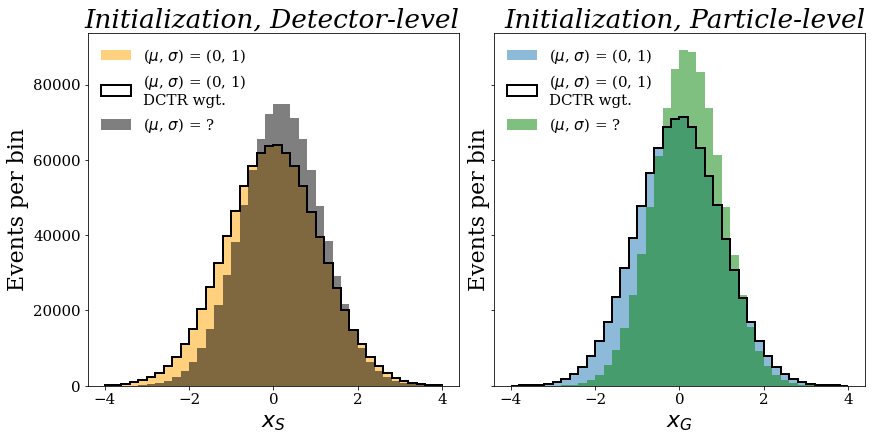

<Figure size 864x360 with 0 Axes>

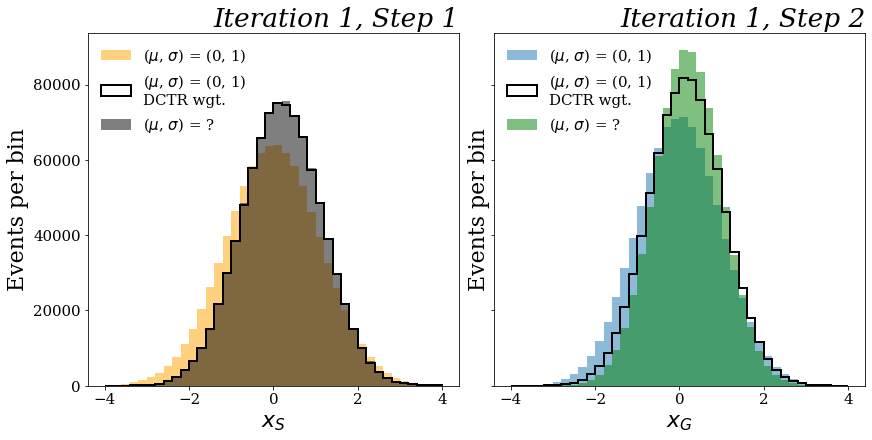

<Figure size 864x360 with 0 Axes>

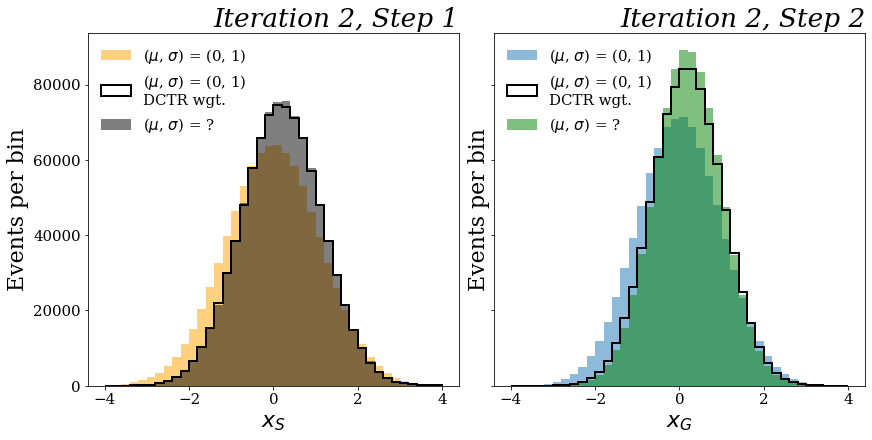

<Figure size 864x360 with 0 Axes>

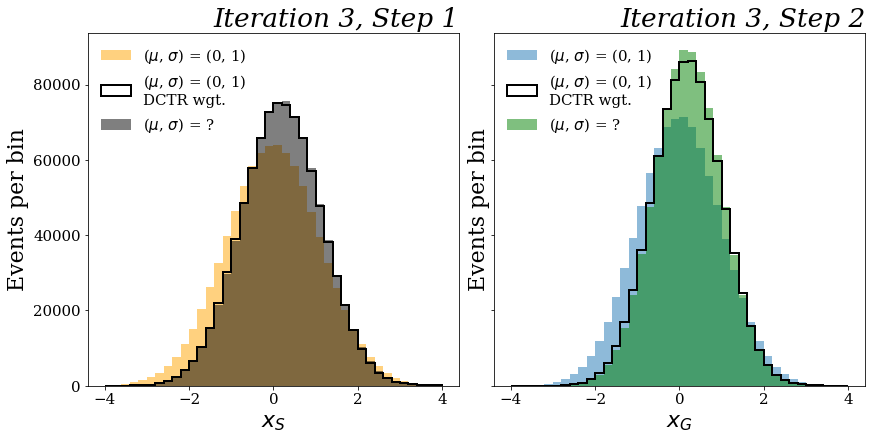

<Figure size 864x360 with 0 Axes>

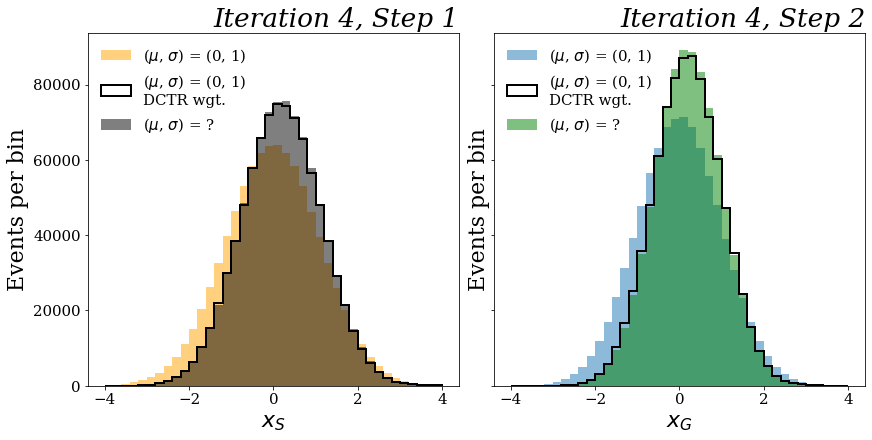

In [51]:
bins = np.linspace(-4, 4, 41)

plt.figure(figsize=(12, 5))

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)

#Detector-level
ax[0].set_title("Initialization, Detector-level",style='italic',loc='right')
hist0 = ax[0].hist(theta0_S[theta0_S!=dummyval],
                 bins=bins,
                 color="orange",
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[0].hist(
    theta0_S[theta0_S!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 weights=weights[i, 0, :][theta_unknown_S!=dummyval],
                 **plot_style_2,
                color="black")
ax[0].legend(frameon=False)
ax[0].set_xlabel(r"$x_S$")
ax[0].set_ylabel("Events per bin")

#Particle-level
ax[1].set_title("Initialization, Particle-level",style='italic',loc='right')
_,_,_=ax[1].hist(theta0_G[theta0_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[1].hist(
    theta0_G[theta0_G!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 **plot_style_2,
                color="green")
ax[1].legend(frameon=False)
ax[1].set_xlabel(r"$x_G$")
ax[1].set_ylabel("Events per bin")

plt.savefig("plot_0.pdf")

#Iterations
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(12, 5))
    
    fig, ax = plt.subplots(1,2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
    
    #Detector-level
    ax[0].set_title("Iteration " +str(i+1)+ ", Step 1",style='italic',loc='right')
    _,_,_ = ax[0].hist(theta0_S[theta0_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     color="orange",
                     **plot_style_2)

    _,_,_ = ax[0].hist(
        theta0_S[theta0_S!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 0, :][theta0_S!=dummyval],
        **plot_style_1)
    _,_,_ = ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="black")
    ax[0].legend(frameon=False)
    ax[0].set_xlabel(r"$x_S$")
    ax[0].set_ylabel("Events per bin")
    
    #Particle-level
    ax[1].set_title("Iteration " +str(i+1)+ ", Step 2",style='italic',loc='right')
    _,_,_ = ax[1].hist(theta0_G[theta0_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     **plot_style_2)

    _,_,_ = ax[1].hist(
        theta0_G[theta0_G!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 1, :][theta0_G!=dummyval],
        **plot_style_1)
    _,_,_ = ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="green")
    ax[1].legend(frameon=False)
    ax[1].set_xlabel(r"$x_G$")
    ax[1].set_ylabel("Events per bin")
    
    plt.savefig("plot_"+str(i+1)+".pdf")

## Owen: inspecting a few things after running everything

In [52]:
weights

array([[[1.09925199, 1.25292814, 1.0269829 , ..., 1.21654189,
         0.94434184, 1.22400451],
        [1.10373008, 1.19896376, 0.95481282, ..., 1.1862613 ,
         1.0245316 , 1.15101039]],

       [[1.07423849, 1.27557111, 0.96775923, ..., 1.25071807,
         1.00150464, 1.20777231],
        [1.09591699, 1.23895191, 0.92874399, ..., 1.23251252,
         1.02236623, 1.19899082]],

       [[1.08064378, 1.28487975, 0.94477562, ..., 1.27666406,
         1.02501825, 1.22685505],
        [1.08478785, 1.25528634, 0.92685619, ..., 1.26765024,
         1.03957957, 1.20221615]],

       [[1.07978219, 1.27266035, 0.93398356, ..., 1.27803159,
         1.02834709, 1.21285287],
        [1.07953131, 1.26624461, 0.92404875, ..., 1.28512889,
         1.04744463, 1.22301555]]])

In [53]:
weights.shape

(4, 2, 1000000)

In [54]:
Input

<function keras.engine.input_layer.Input(shape=None, batch_size=None, name=None, dtype=None, sparse=None, tensor=None, ragged=None, type_spec=None, **kwargs)>

In [55]:
Model

keras.engine.training.Model

In [56]:
x_data_and_MCback

array([-1.57518614, -6.24711073, -4.60056294, ..., -3.83882748,
       -1.59496588,  0.55076366])

In [57]:
x_data_and_MCback.shape

(2400252,)

In [58]:
y_data_and_MCback

array([1., 1., 1., ..., 0., 0., 0.])

In [59]:
y_data_and_MCback.shape

(2400252,)

In [60]:
W_data_and_MCback

array([-1., -1., -1., ...,  1.,  1.,  1.])

In [61]:
W_data_and_MCback.shape

(2400252,)

In [62]:
w_data

array([0.92023456, 0.46898642, 0.9132864 , ..., 0.00728895, 0.7340871 ,
       0.9237836 ], dtype=float32)

In [63]:
w_data.shape

(1100126,)

In [64]:
theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]

array([ 0.68574756,  2.47799665,  0.77593016, ..., -3.83882748,
       -1.59496588,  0.55076366])

In [65]:
theta_unknown_S_withback[theta_unknown_S_withback!=dummyval].shape

(1100126,)

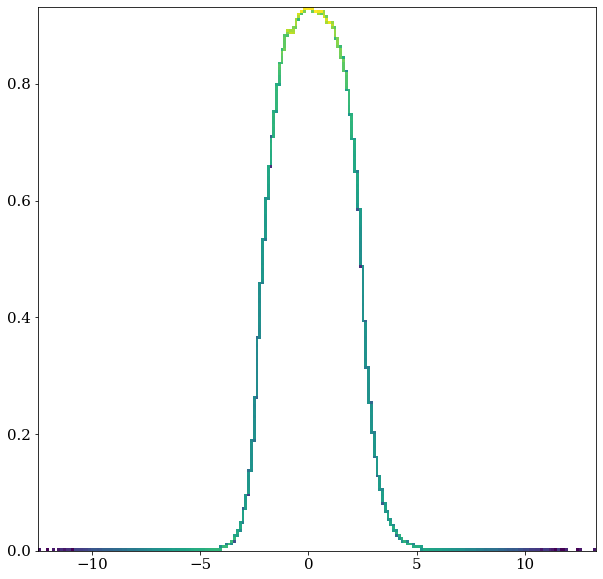

In [66]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data,
         density=True,
         bins=200,
         norm=mpl.colors.LogNorm())

plt.show()

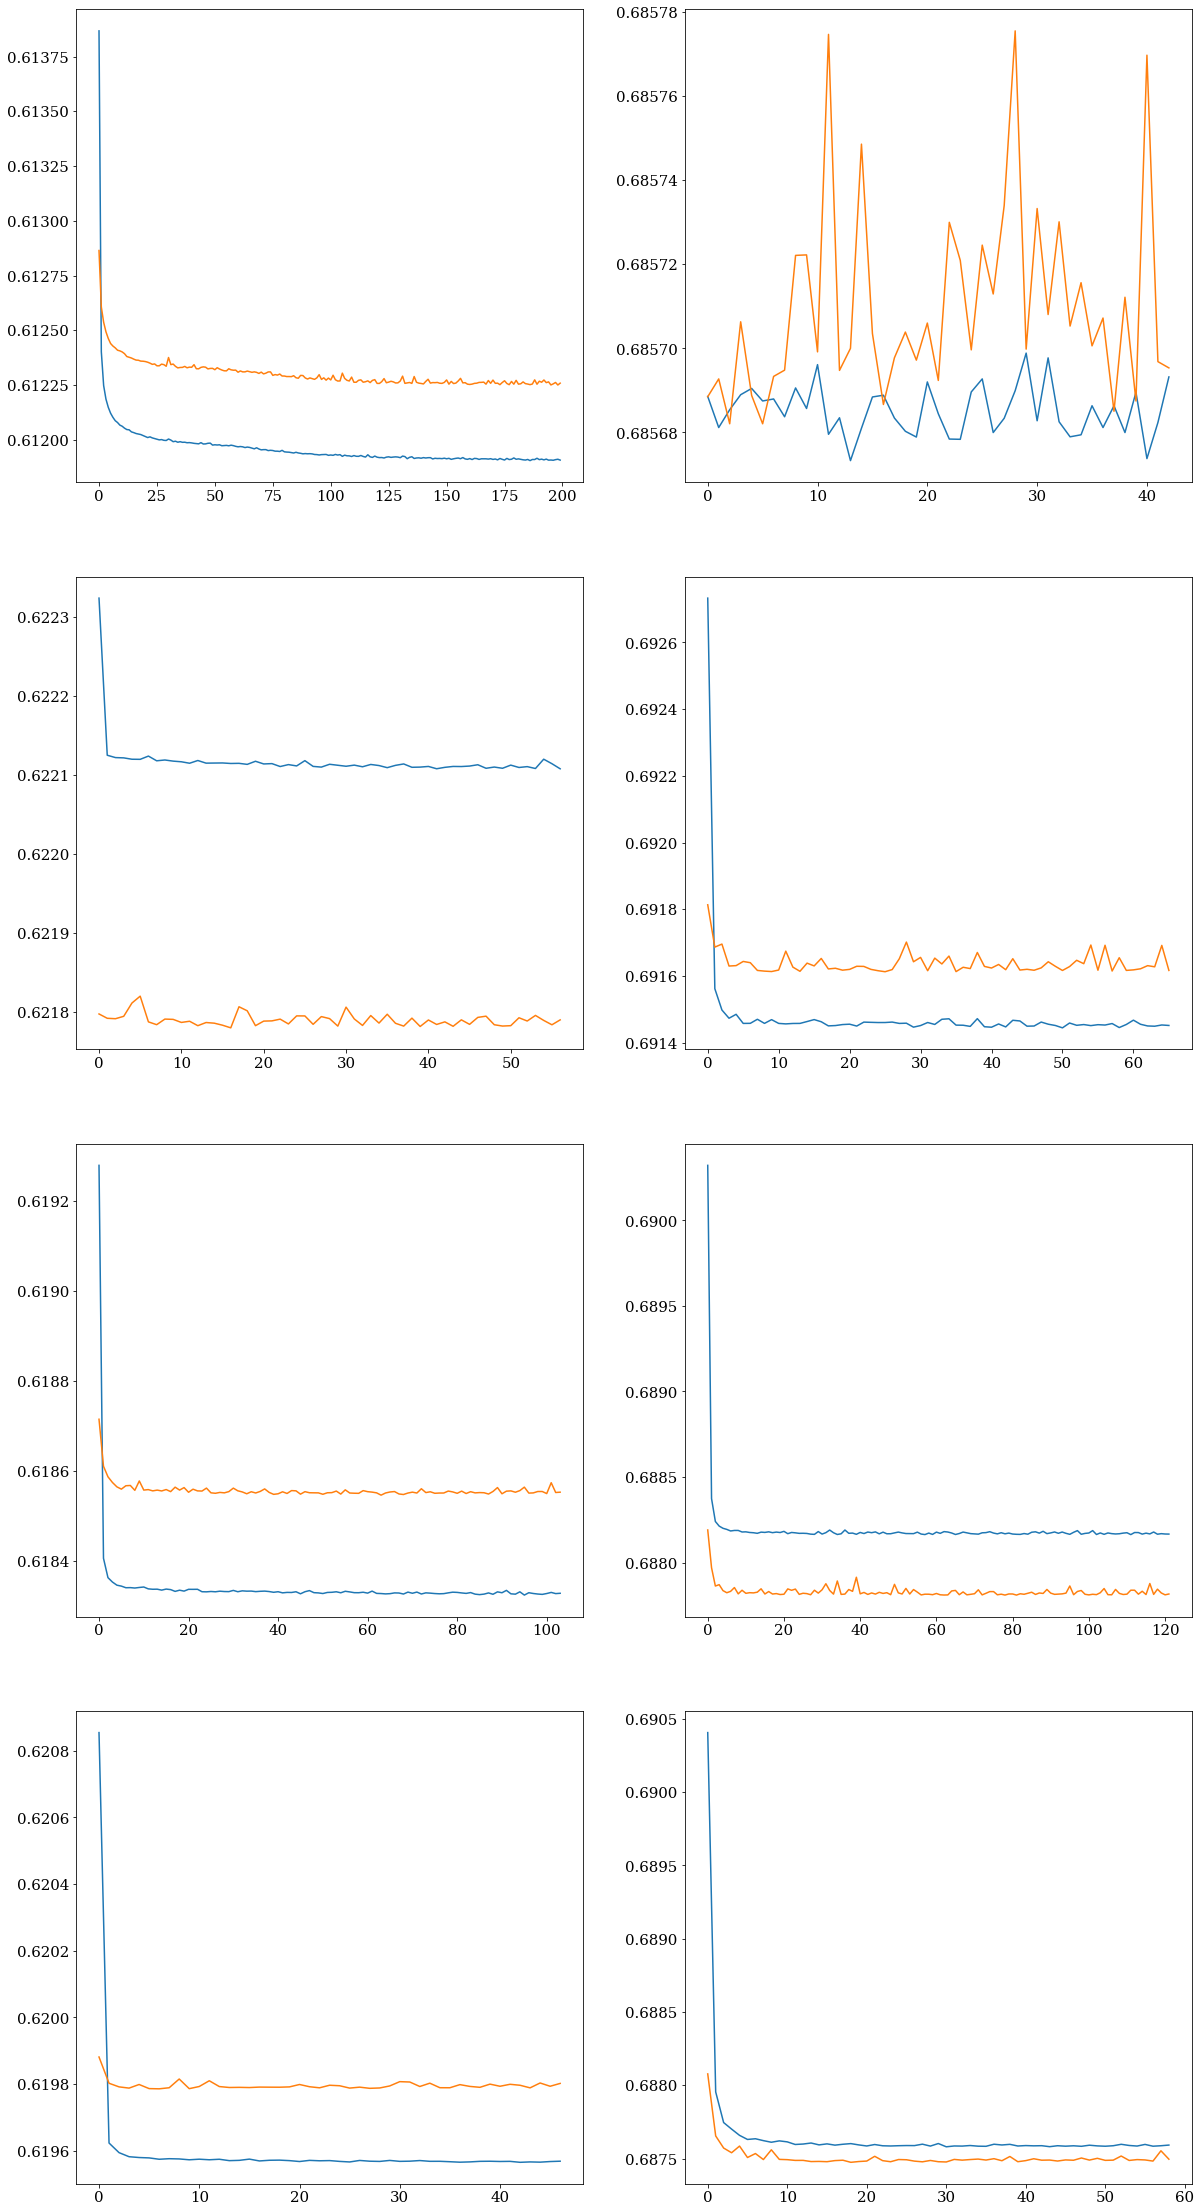

In [67]:
fig,ax = plt.subplots(4,2,figsize=(20,40))

for i in range(0,4):
    
    ax[i][0].plot( of_training_history[i][0][of_training_history[i][0]>0] )
    ax[i][0].plot( of_training_history_val[i][0][of_training_history[i][0]>0] )
    
    ax[i][1].plot( of_training_history[i][1][of_training_history[i][1]>0] )
    ax[i][1].plot( of_training_history_val[i][1][of_training_history[i][1]>0] )    
    
plt.show()

## distributions of weights

### Weights on full simulation to match data (step1)

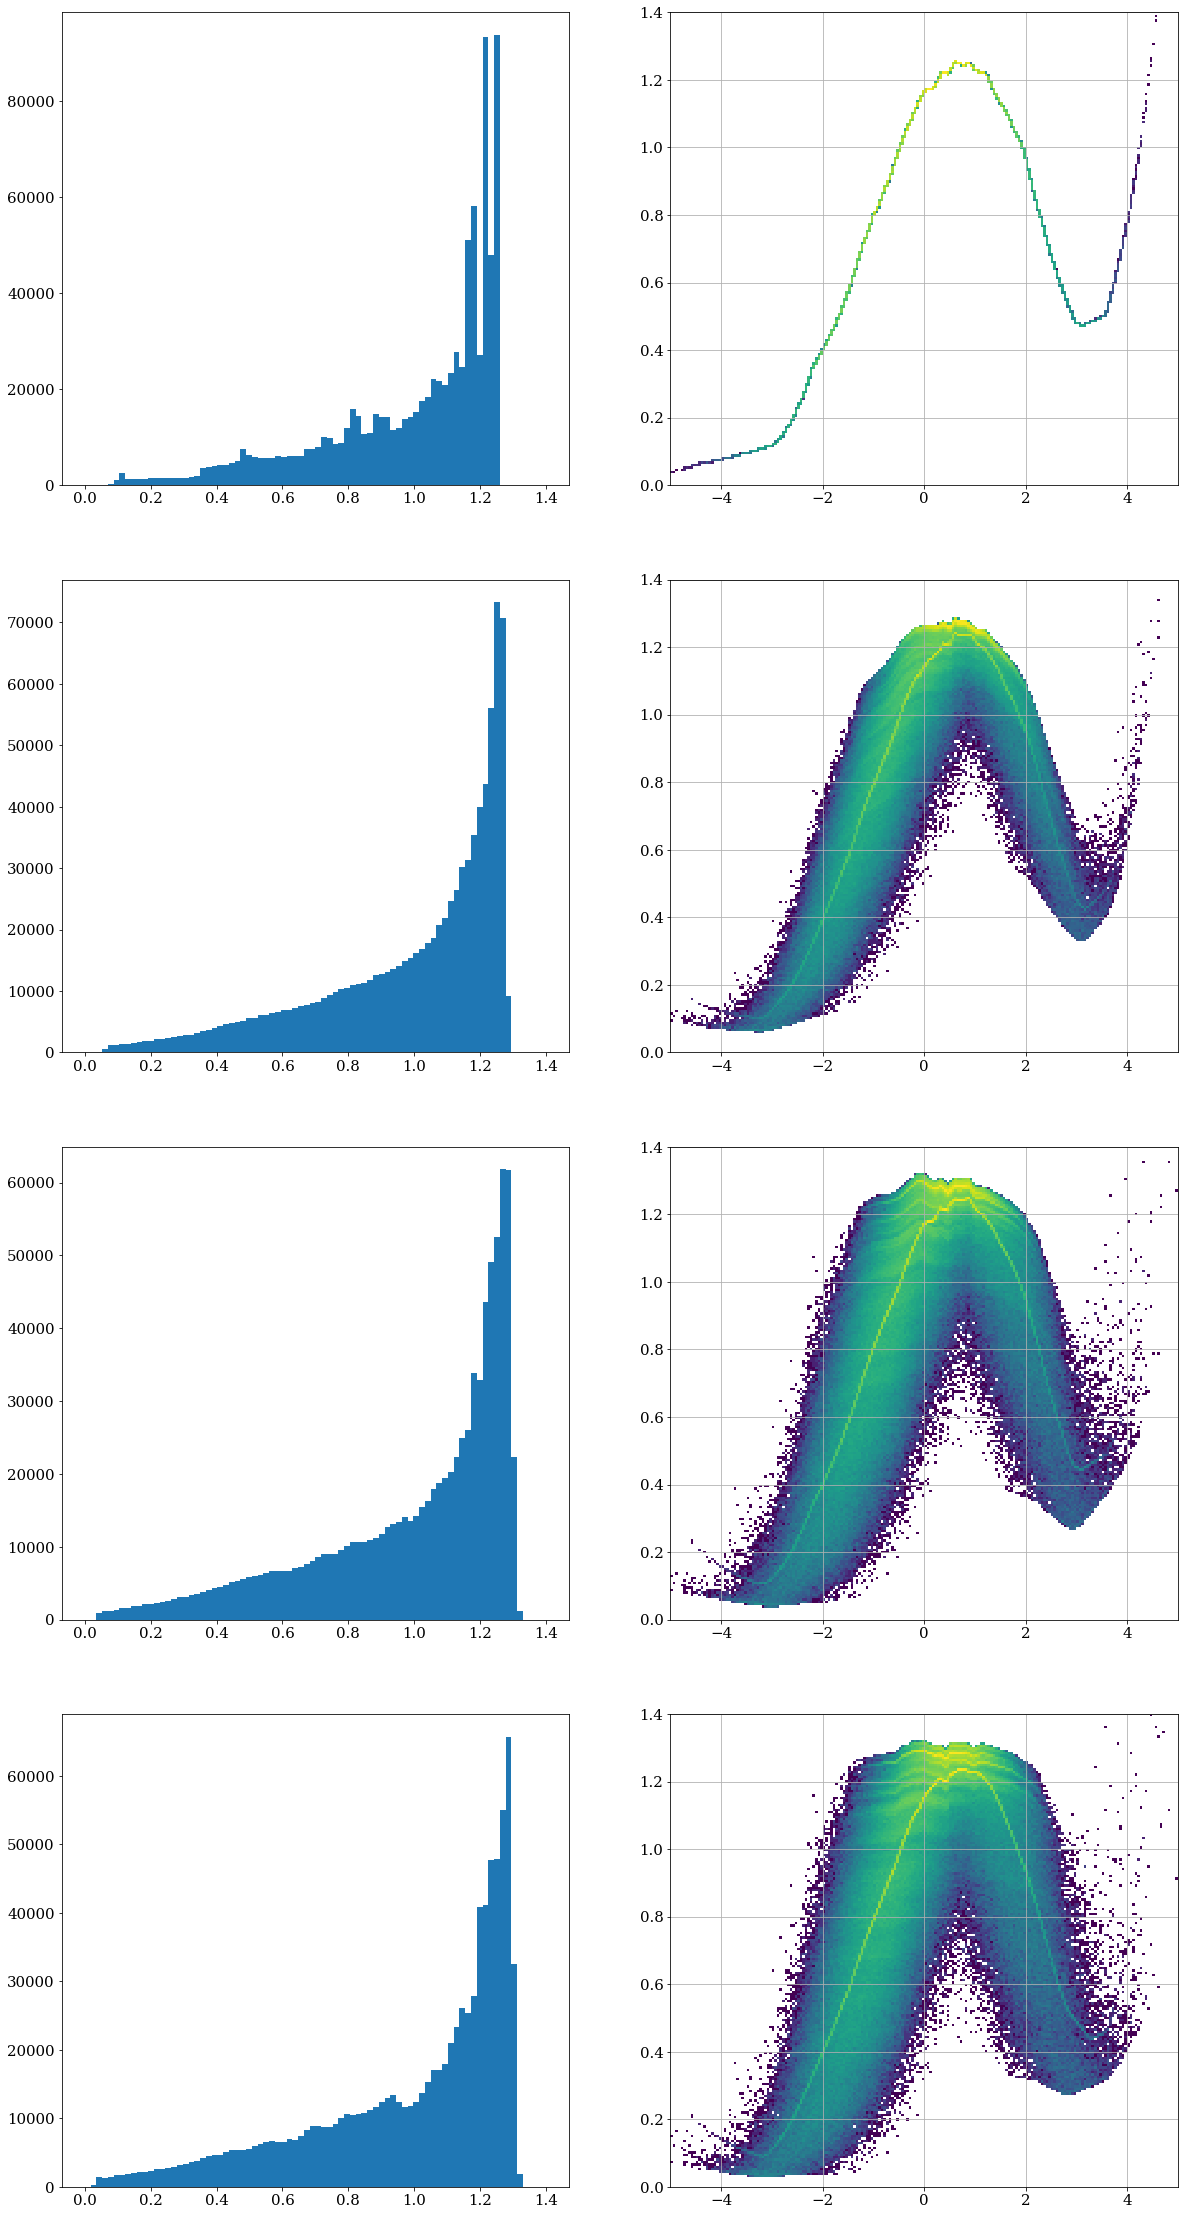

In [68]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( weights[i,0,theta0_S!=dummyval], bins=80, range=[0,1.4] )
    
    ax[i][1].hist2d( theta0_S[theta0_S!=dummyval], weights[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1.4]))
    ax[i][1].grid()
    
plt.show()

### Weights on gen (step2)

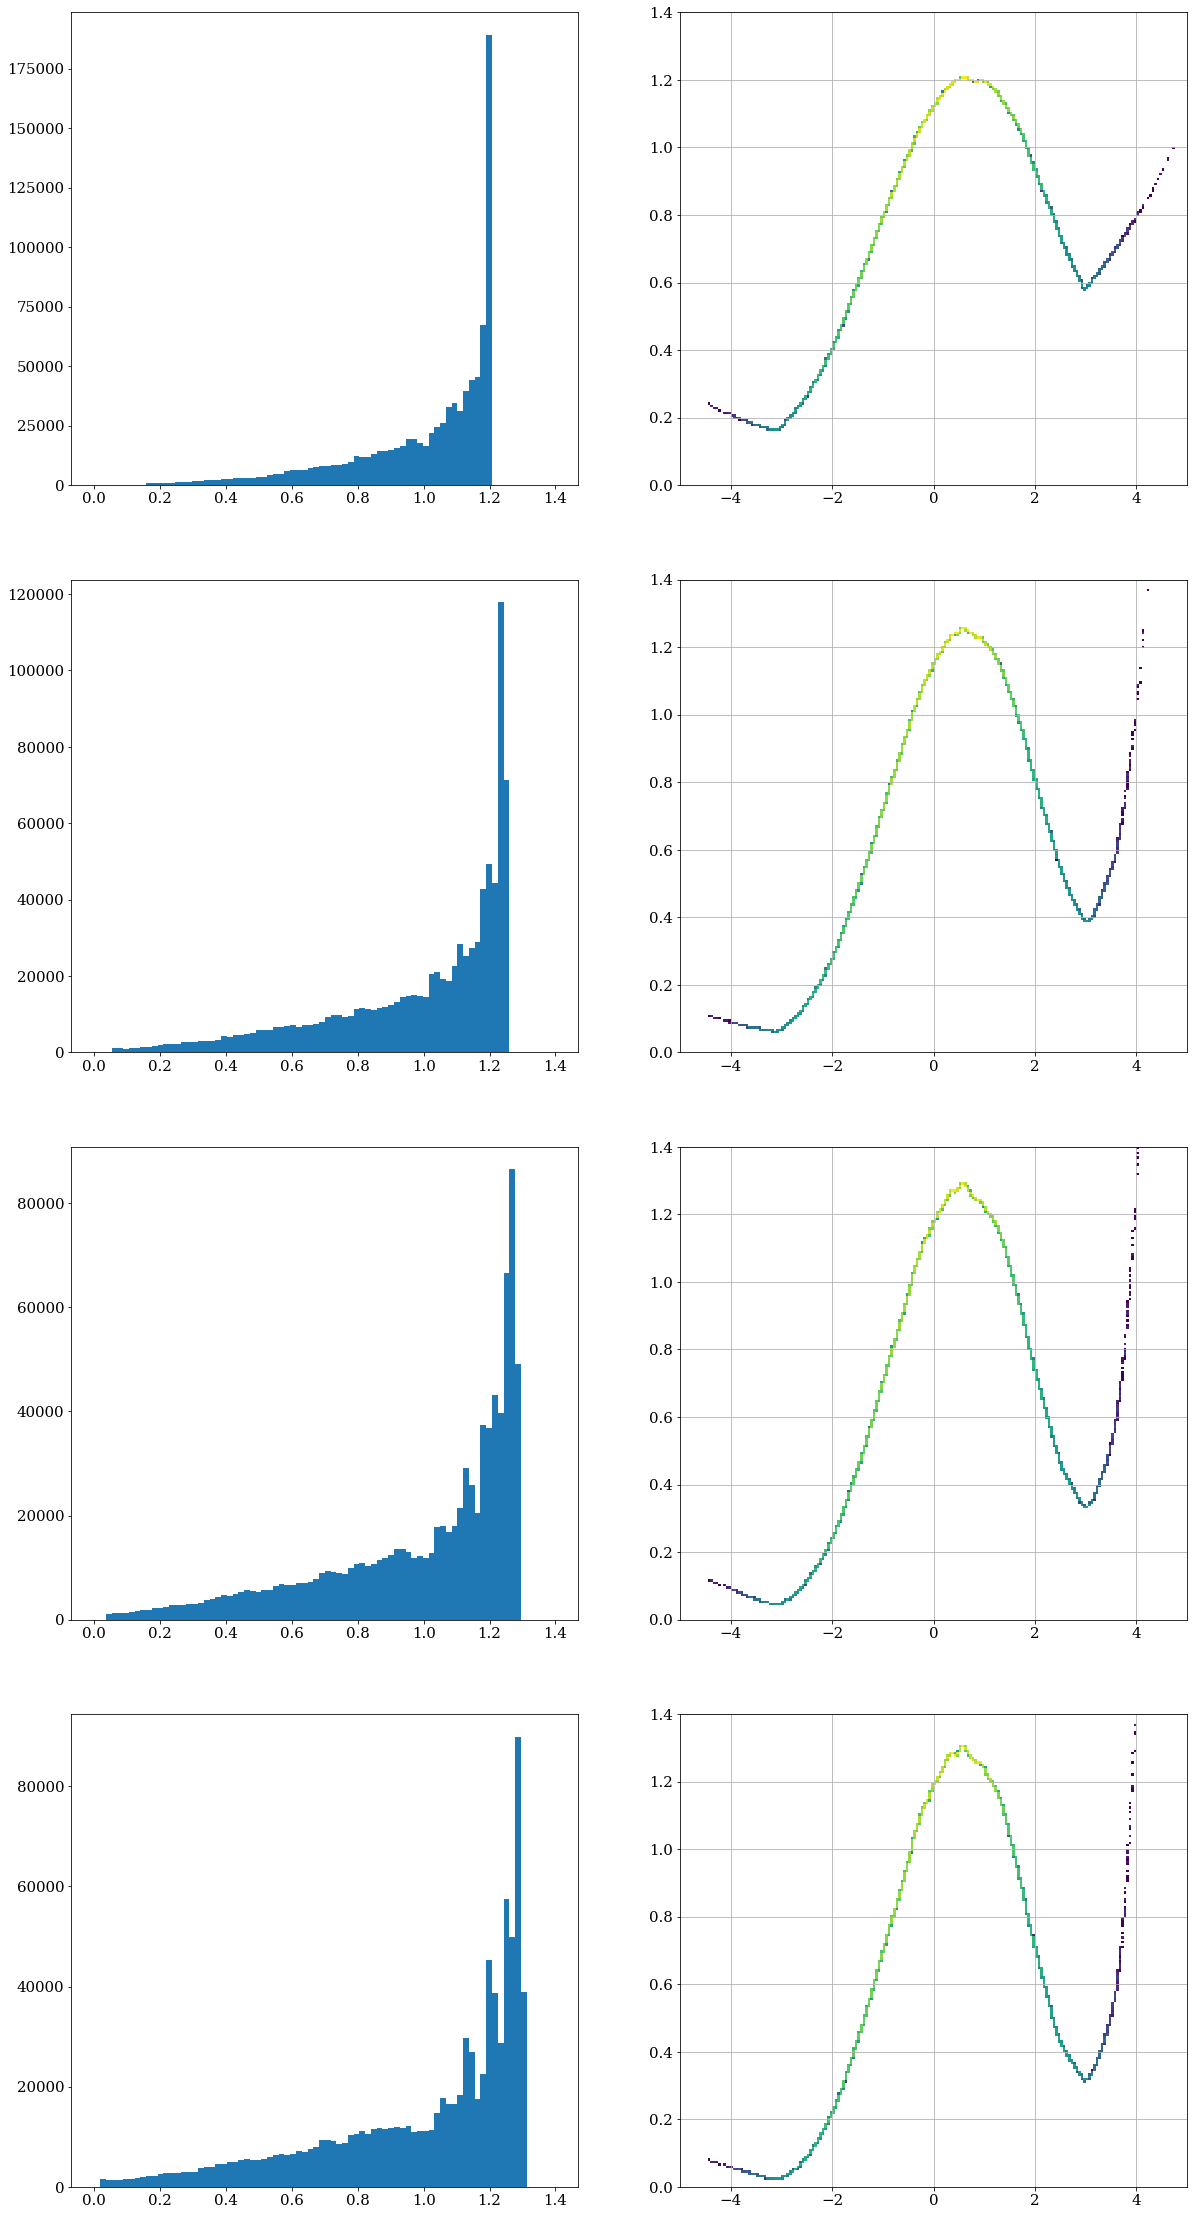

In [69]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( weights[i,1,theta0_G!=dummyval], bins=80, range=[0,1.4] )
    
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], weights[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1.4]))
    ax[i][1].grid()
    
plt.show()

## Change in weights on fullsim (step1) between consecutive iterations

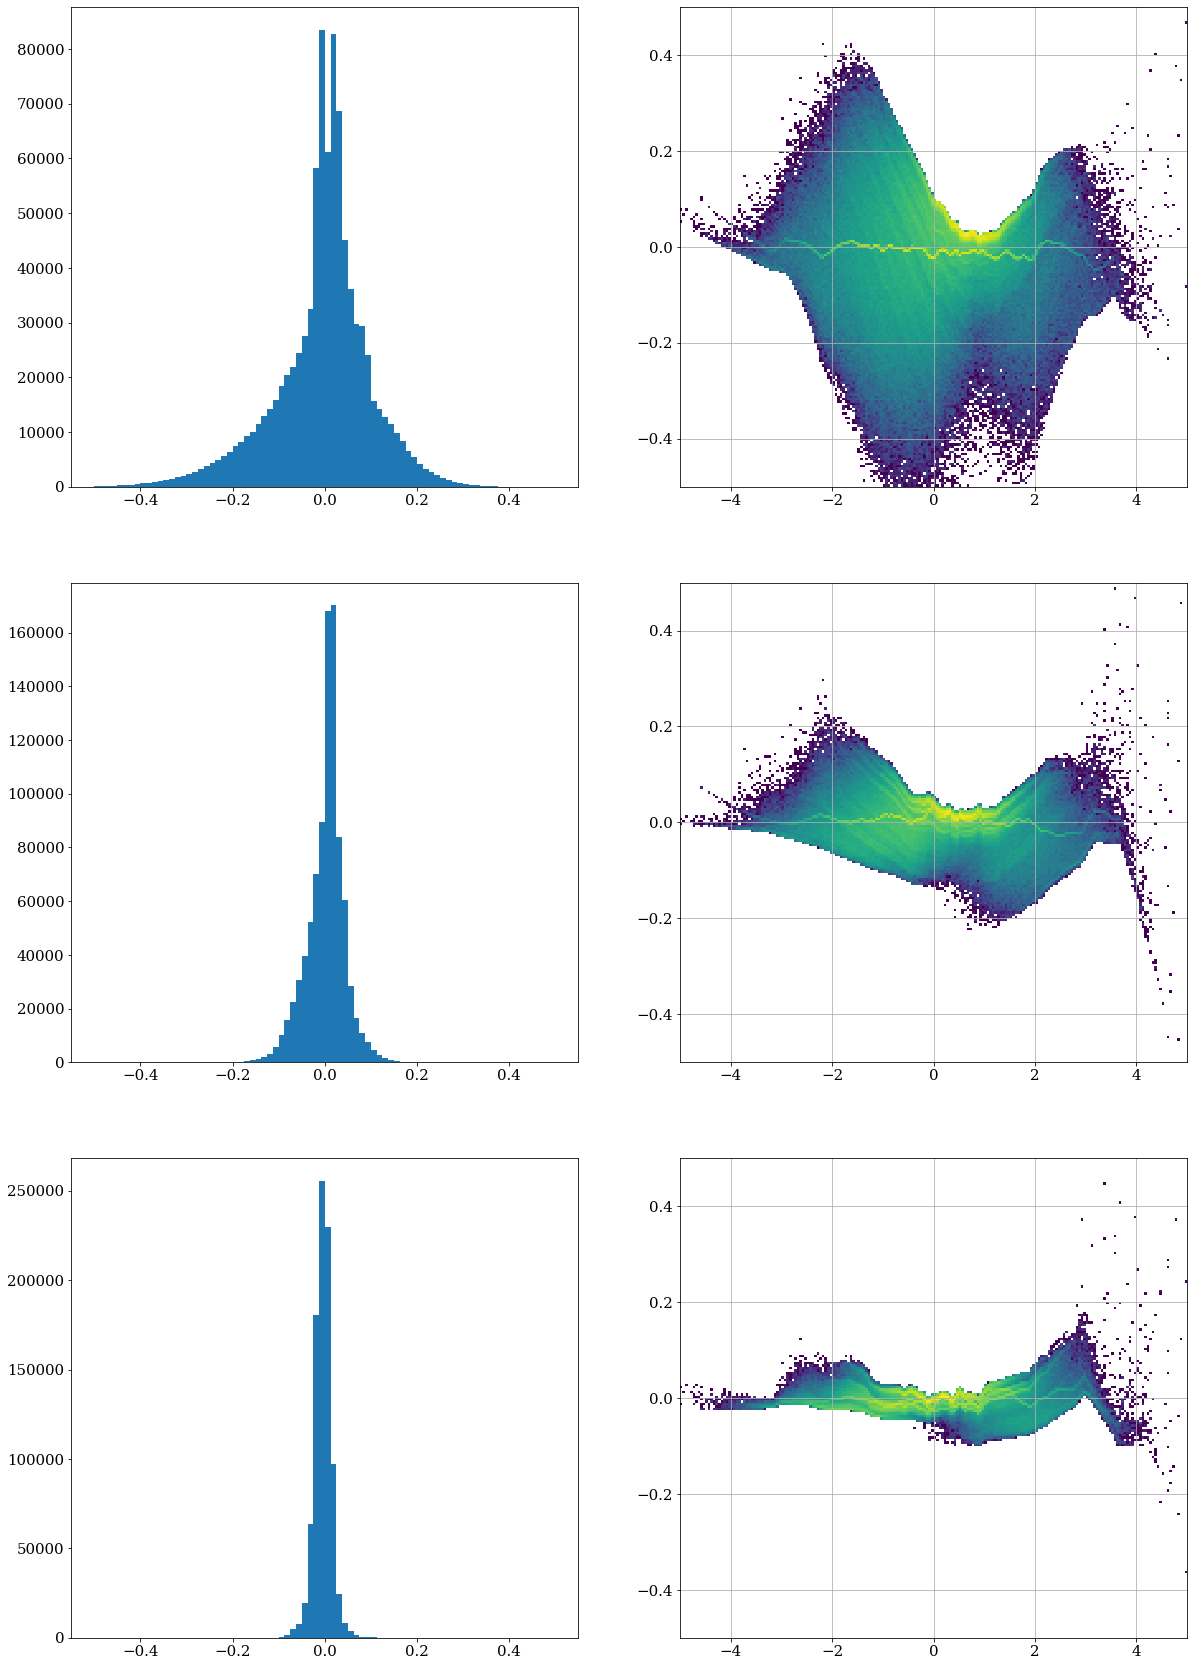

In [70]:
fig,ax = plt.subplots(iterations-1,2,figsize=(20,30))

for i in range(0,iterations-1):
    
    ax[i][0].hist( weights[i+1,0,theta0_S!=dummyval]-weights[i,0,theta0_S!=dummyval], bins=80,
                 range=[-0.5,0.5])
    
    ax[i][1].hist2d( theta0_S[theta0_S!=dummyval], weights[i+1,0,theta0_S!=dummyval]-weights[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[-0.5,0.5]))
    ax[i][1].grid()
    
plt.show()

## Change in weights on gen (step2) between consecutive iterations

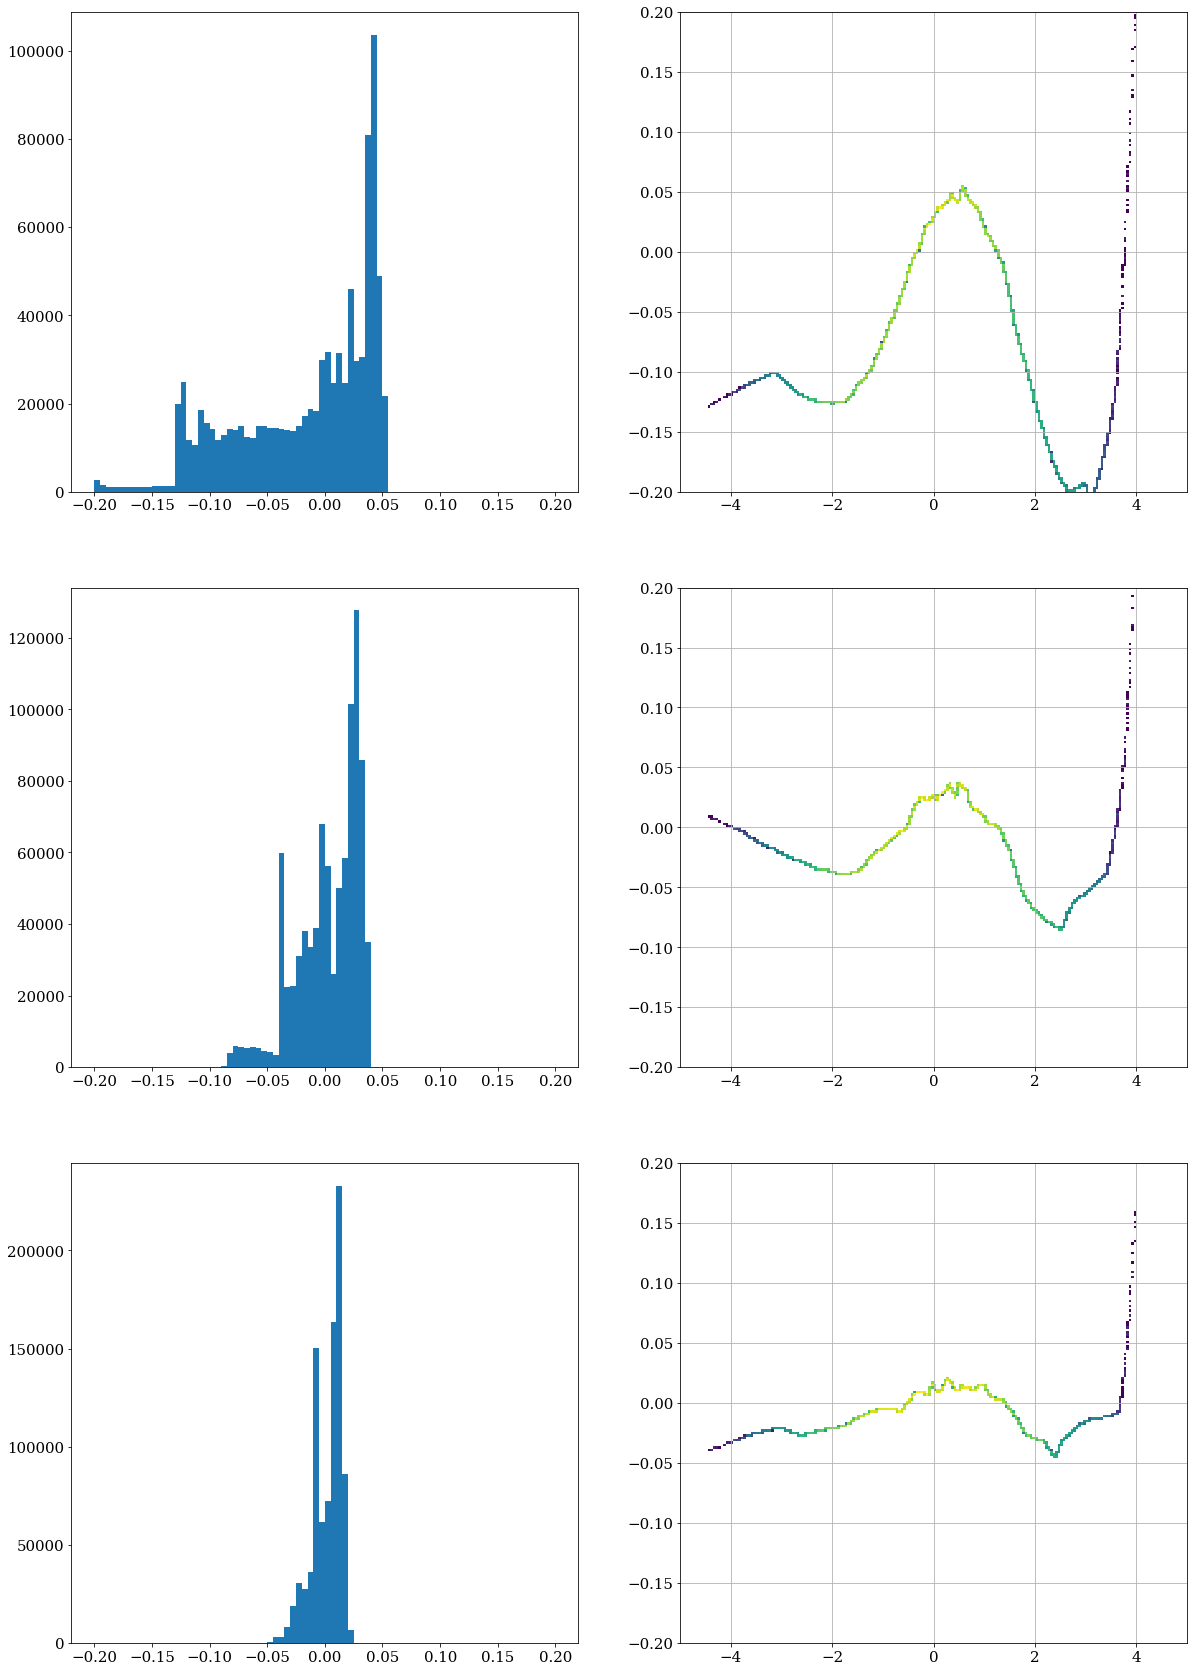

In [71]:
fig,ax = plt.subplots(iterations-1,2,figsize=(20,30))

for i in range(0,iterations-1):
    
    ax[i][0].hist( weights[i+1,1,theta0_G!=dummyval]-weights[i,1,theta0_G!=dummyval], bins=80,
                 range=[-0.2,0.2])
    
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], weights[i+1,1,theta0_G!=dummyval]-weights[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[-0.2,0.2]))
    ax[i][1].grid()
    
plt.show()

In [72]:
nn_output

array([[[0.52363986, 0.55613321, 0.50665593, ..., 0.54884678,
         0.48568717, 0.55036062],
        [0.49714994, 0.54524034, 0.48844209, ..., 0.54259813,
         0.50605857, 0.49714994]],

       [[0.49322957, 0.51547915, 0.50336695, ..., 0.51322472,
         0.49431723, 0.51203203],
        [0.493617  , 0.5082013 , 0.49307987, ..., 0.50956088,
         0.49947104, 0.493617  ]],

       [[0.49649143, 0.50909883, 0.50427848, ..., 0.508798  ,
         0.50064766, 0.50574321],
        [0.50262195, 0.50327444, 0.4994913 , ..., 0.50702709,
         0.50417405, 0.50262195]],

       [[0.49884373, 0.50343639, 0.5019151 , ..., 0.50203902,
         0.49728411, 0.50220215],
        [0.4983114 , 0.50217295, 0.49924162, ..., 0.50342345,
         0.50188428, 0.4983114 ]]])

## Output of NN for step1: distinguish data from fullsim

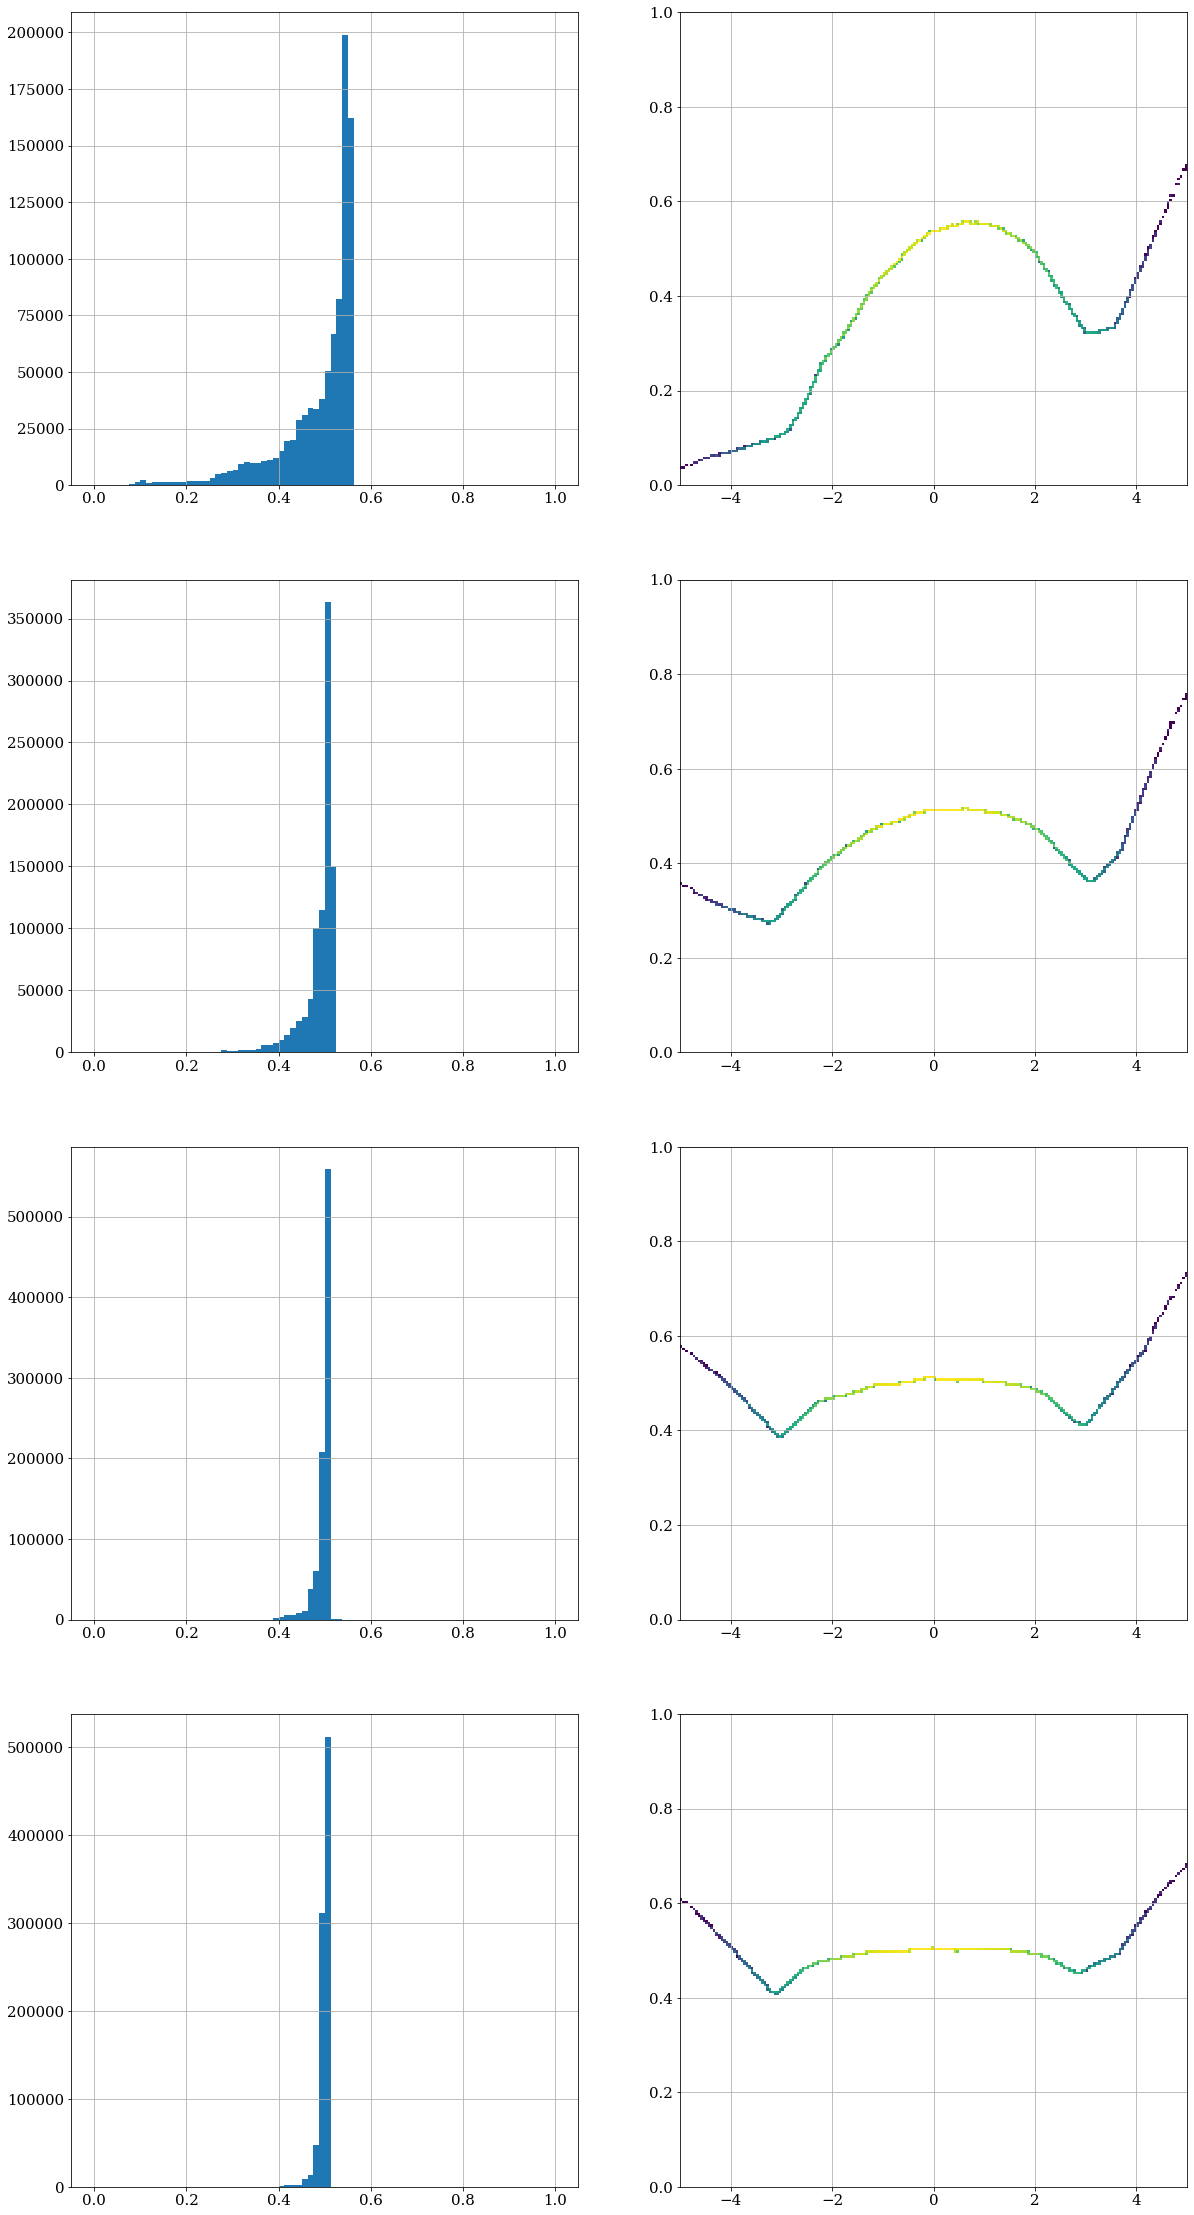

In [73]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( nn_output[i,0,theta0_S!=dummyval], bins=80, range=[0,1] )
    ax[i][0].grid()
    
    ax[i][1].hist2d( theta0_S[theta0_S!=dummyval], nn_output[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1]))
    ax[i][1].grid()
    
plt.show()

## NN output of step2 : distinguish gen

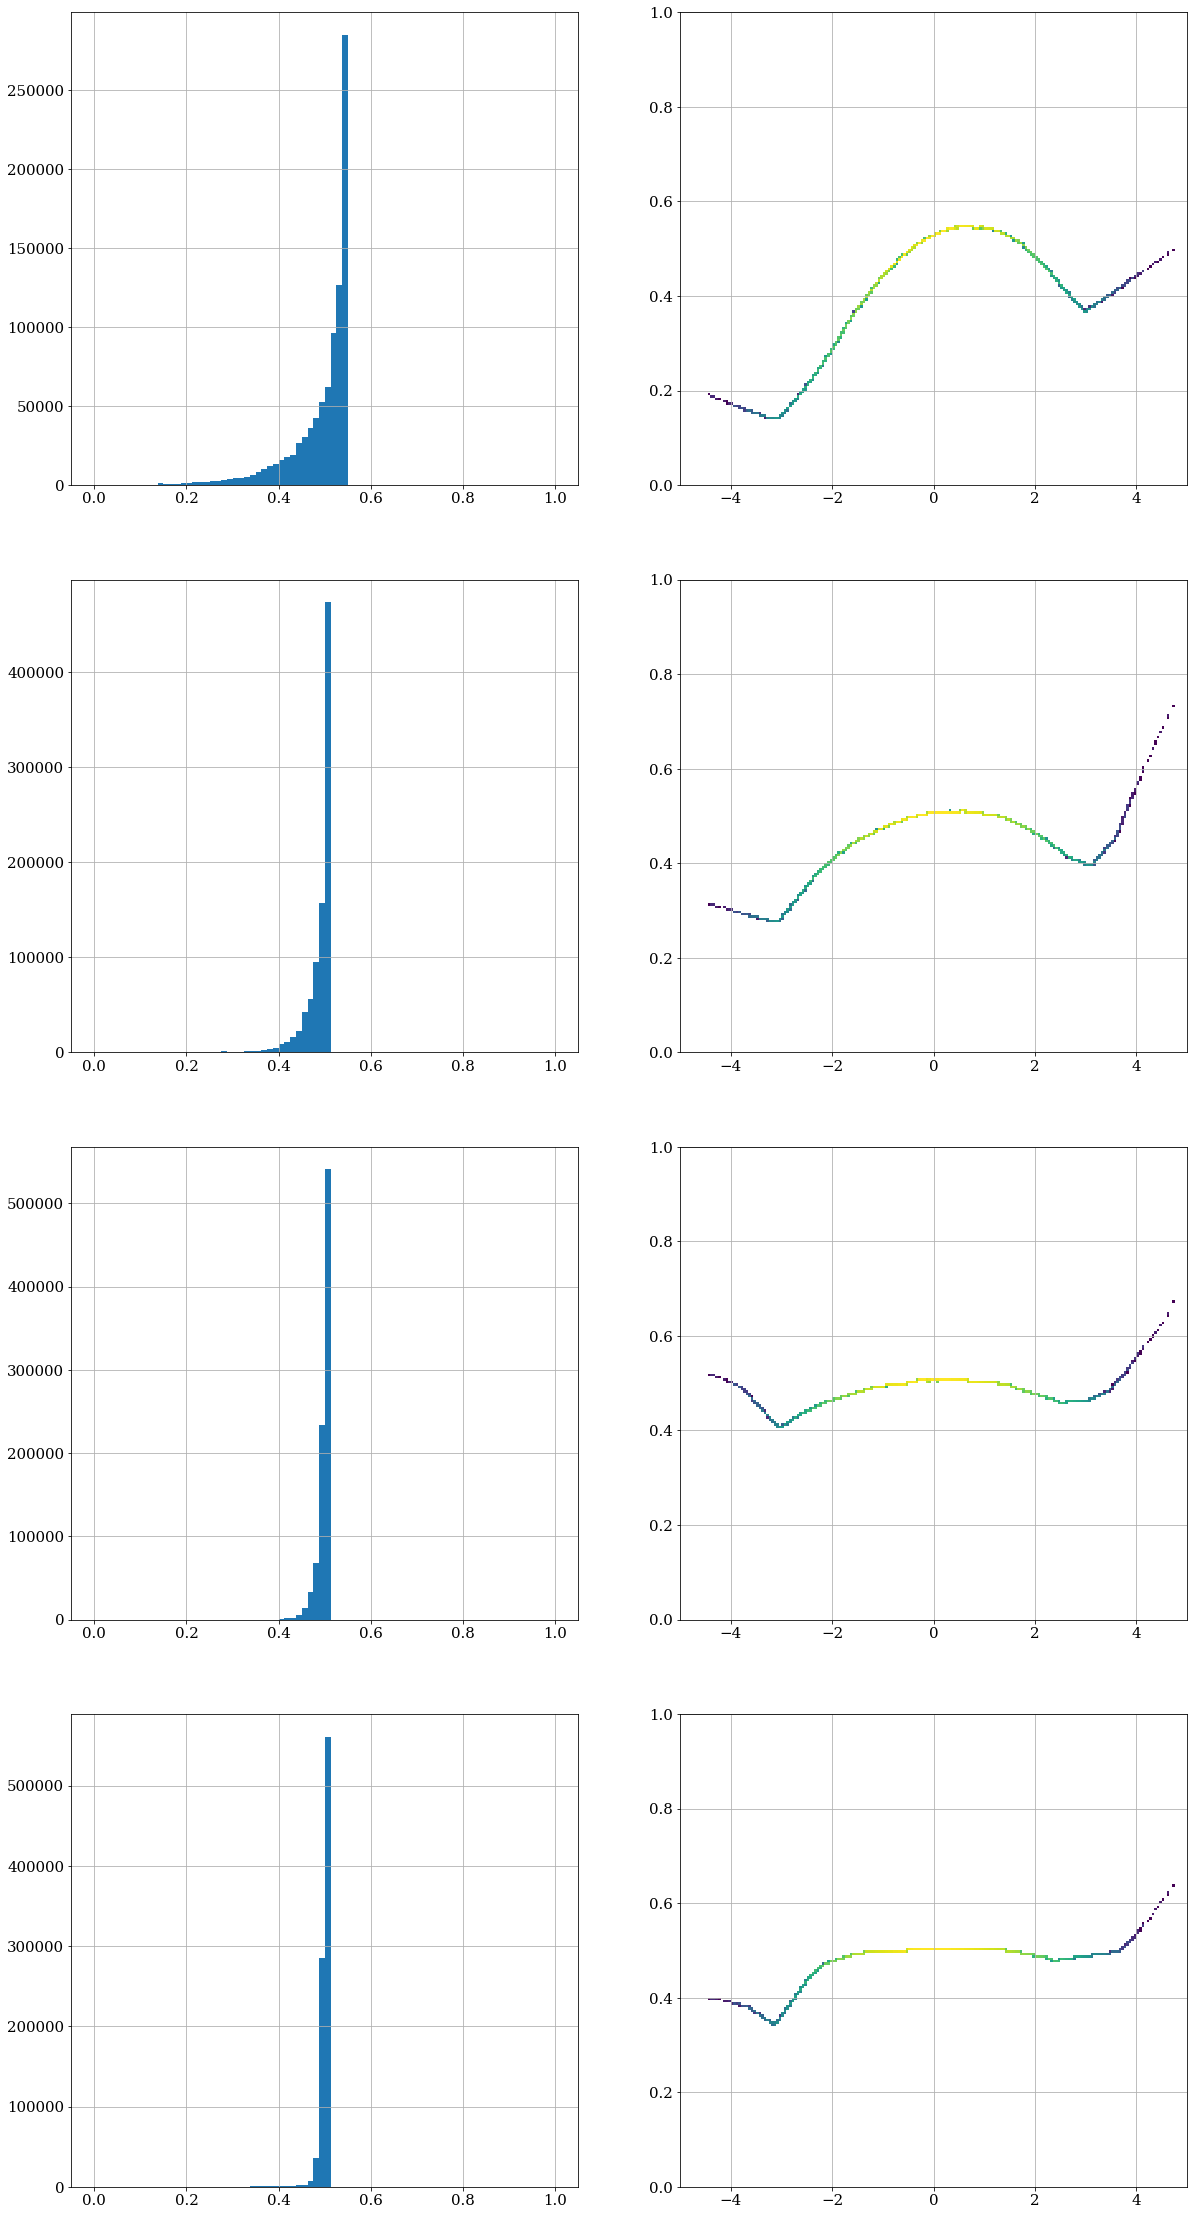

In [74]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( nn_output[i,1,theta0_G!=dummyval], bins=80, range=[0,1] )
    ax[i][0].grid()
    
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], nn_output[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1]))
    ax[i][1].grid()
    
plt.show()